Обращение к ревьюверу

# Описание:  
**Название проекта**

Проект: Второй сборный проект

**Описание исследования.**



**Цель исследования.**



**Действия, необходимые для достижения поставленной цели.**

Загрузить данные;  
Обработать;  
Проанализировать их;  
Выявить корреляции в данных;   
Подготовить данные для МО и обучить модель;  
Проверить метрики модели;
Выполнить предсказания используя модель;
Сделать вывод по проделанной работе;

**Исходные данные.**




**Данное исследование разделено по плану:**  
[1.Загрузка данных](#t001)  
[2. Предобработка данных](#t002)   
[3. Исследовательский анализ данныхъ](#t003)  
[4. Объединение таблиц](#t004)  
[5. Корреляционный анализ](#t005)  
[6. Использование пайплайнов](#t006)  
[7. Анализ важности признаков](#t007)  
[8. Сегментация покупателей](#t008)
[9. Общий вывод](#t009)

# 0. Подготовительные шаги и функции  


## Импортирую библиотеки

In [1]:
#%pip install phik
#%pip install shap
#%pip install scikit-learn-intelex
import os
import phik
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import kstest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder


from sklearnex import patch_sklearn
patch_sklearn()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Объявляю константы  

In [2]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'
#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'
#список имен датафреймов 
DF_NAMES = ['df_train_job_satisfaction_rate', 'df_test_features', 'df_test_target_job_satisfaction_rate', 'df_train_quit', 'df_test_target_quit']
# конатстна новой строки для использования в f' строках
NL = '\n'

RANDOM_STATE = 42

## Объявляю функции

In [3]:
def smape(a, f):
 return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

<a id='t001'></a>
# 1. Загрузка данных 
## Для выполнения задачи заказчиком были переданы три набора данных  

Т.к. работу выполнял локально, в VScode добавил проверку где выполняется проект. Если не локально, то брать из расположения в тренажере.

## 1.1 Загрузка данных  

Решил немного упростить себе задачу и разложить данные из всех файлов по своим датафреймам сразу для первой и сторой задачи.

In [4]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    elif os.path.exists(TRAINER_DATA_PATH):
         globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f.strip('df_') + '.csv', index_col='id')
    else:
        print('ALARMA! No files found!')

Посмотрю на то, что загрузилось.

In [5]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].sample(5).T)

Датасет df_train_job_satisfaction_rate


id,309989,690132,432478,248320,125347
dept,sales,hr,sales,marketing,marketing
level,junior,sinior,middle,junior,middle
workload,medium,high,high,medium,low
employment_years,2,9,9,1,6
last_year_promo,no,yes,no,no,no
last_year_violations,no,no,no,no,no
supervisor_evaluation,3,5,4,4,4
salary,25200,70800,58800,27600,31200
job_satisfaction_rate,0.53,0.76,0.86,0.7,0.78


Датасет df_test_features


id,709750,275298,776933,520788,568103
dept,hr,hr,technology,sales,purchasing
level,middle,middle,middle,junior,middle
workload,low,low,medium,medium,medium
employment_years,3,4,8,2,10
last_year_promo,no,no,no,no,no
last_year_violations,no,no,no,no,yes
supervisor_evaluation,1,2,5,5,3
salary,19200,19200,46800,28800,33600


Датасет df_test_target_job_satisfaction_rate


id,509176,648081,264208,627748,148984
job_satisfaction_rate,0.89,0.49,0.82,0.67,0.65


Датасет df_train_quit


id,531704,657404,205543,640349,267691
dept,marketing,sales,marketing,sales,technology
level,middle,junior,middle,middle,middle
workload,medium,medium,medium,medium,medium
employment_years,4,1,6,6,6
last_year_promo,yes,no,yes,no,no
last_year_violations,no,no,no,no,no
supervisor_evaluation,3,4,2,5,4
salary,40800,25200,34800,33600,45600
quit,no,no,no,no,no


Датасет df_test_target_quit


id,689909,979408,179244,746619,420616
quit,no,yes,no,yes,yes


## 1.2 Проверка содержимого в загруженных данных

Просмотрел загруженные данные. Сверил их с описанием. Несоответствия описанным данным не обнаружил.

<a id='t002'></a>  
# 2. Предобработка данных

## Посмотрю соответствие типов столбцов описанным в задаче типам.

In [6]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].info(True))

Датасет df_train_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

Датасет df_test_features
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

Датасет df_test_target_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

Датасет df_train_quit
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

Датасет df_test_target_quit
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

Типы данных соответствуют хранимым ими данным. Пропуски наблюдаются в таблицах: **df_test_features, df_train_job_satisfaction_rate**. Их я буду обрабатывать позже, по условию задания, в паплайне.

## Проверю таблицы на дубликаты

##### Выведу список явных дубликатов

In [7]:
for f in DF_NAMES:
    print(f'В датасете {f} найдено дубликатов: {globals()[f].duplicated().sum()}')

В датасете df_train_job_satisfaction_rate найдено дубликатов: 245
В датасете df_test_features найдено дубликатов: 557
В датасете df_test_target_job_satisfaction_rate найдено дубликатов: 1902
В датасете df_train_quit найдено дубликатов: 1413
В датасете df_test_target_quit найдено дубликатов: 1998


Явных нет. Поищу неявные.

Для каждой таблицы сформирую список столбцов с категоримальными данными, а остальные будут численными.

In [8]:
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_' + f.strip('df_')] = globals()[f].select_dtypes(include='object').columns.to_list()
    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_' + f.strip('df_')]]
    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

Столбцы датафрейма df_train_job_satisfaction_rate
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Столбцы датафрейма df_test_features
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_job_satisfaction_rate
Категориальные столбцы: 
 []
Численные столбцы: 
 ['job_satisfaction_rate'] 

Столбцы датафрейма df_train_quit
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_quit
Категориальные столбцы: 
 ['quit']
Численные столбцы: 
 [] 



Взгляну на уникальные значения в категориальных столбцах. Не исключено, что в них могут быть очепятки и\или иные артефакты.

In [9]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    for c in globals()['col_cat_' + f.strip('df_')]:
        print(f"Уникальные значения столбца {c}:\n"  
              f"{(globals()[f][c]).unique()}")
    print('\n')

Датафрейм df_train_job_satisfaction_rate
Уникальные значения столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'high' 'low']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_test_features
Уникальные значения столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'low' 'high' ' ']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_test_target_job_satisfaction_rate


Датафрейм df_train_quit
Уникальные значения столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения столбца level:
['middle' 'junior' 'sinior']
Уникальные з

В **df_test_features** столбцы _dept, level и workload_, и в таблице **df_test_target_quit** столбец _dept_ содержат пропуски. Об этом было указано чуть раньше, а обработаю это в конвеере.

**Вывод:** данные в датафреймах не содержат явных или неявных дублей. Присутствуют пропуски.

<a id='t003'></a>  
# 3. Исследовательский анализ данных

## Выведу описательную статистику по каждой таблице

In [10]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    print(f"{(globals()[f]).describe()}")
        
    print('\n')

Датафрейм df_train_job_satisfaction_rate
       employment_years  supervisor_evaluation        salary  \
count       4000.000000            4000.000000   4000.000000   
mean           3.718500               3.476500  33926.700000   
std            2.542513               1.008812  14900.703838   
min            1.000000               1.000000  12000.000000   
25%            2.000000               3.000000  22800.000000   
50%            3.000000               4.000000  30000.000000   
75%            6.000000               4.000000  43200.000000   
max           10.000000               5.000000  98400.000000   

       job_satisfaction_rate  
count            4000.000000  
mean                0.533995  
std                 0.225327  
min                 0.030000  
25%                 0.360000  
50%                 0.560000  
75%                 0.710000  
max                 1.000000  


Датафрейм df_test_features
       employment_years  supervisor_evaluation        salary
count       2

По описательной статистике можно сказать, что аномалий в данных не наблюдаются. Значение дисперсии и среднего ожидаемые.

## Построю графики

#### Категориальные признаки

Гистограмма распределения значений для таблицы df_train_job_satisfaction_rate


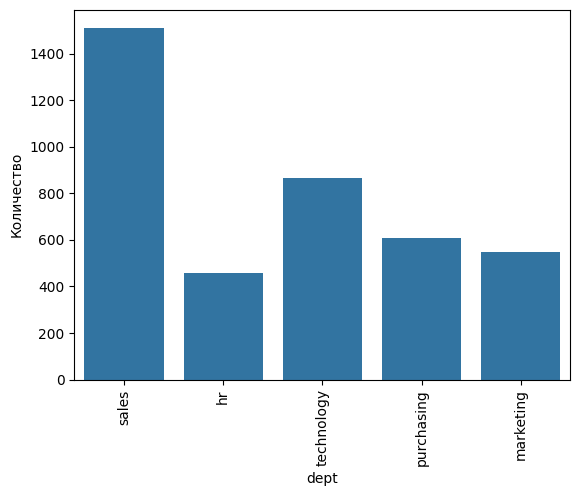

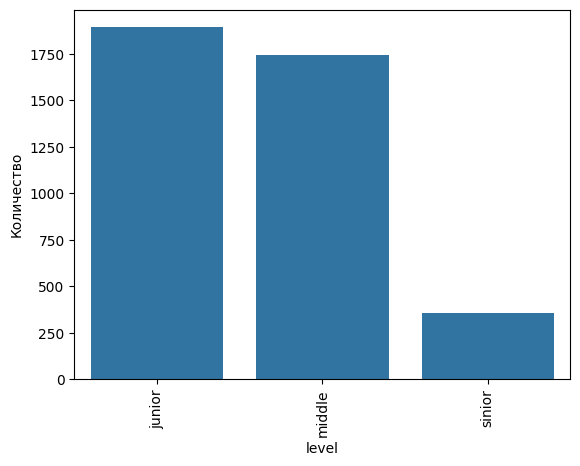

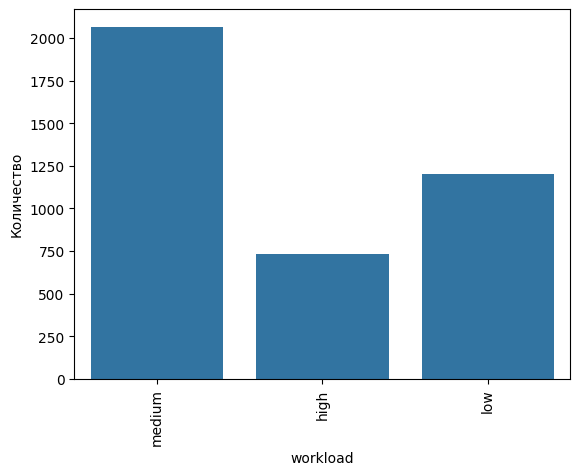

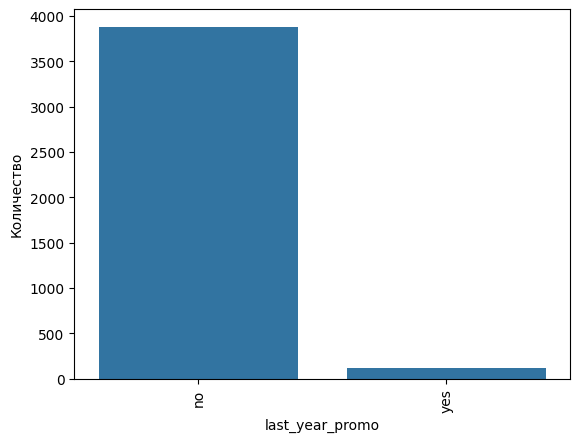

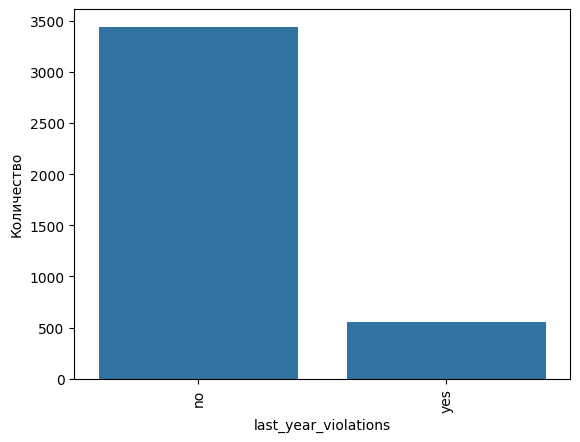

Гистограмма распределения значений для таблицы df_test_features


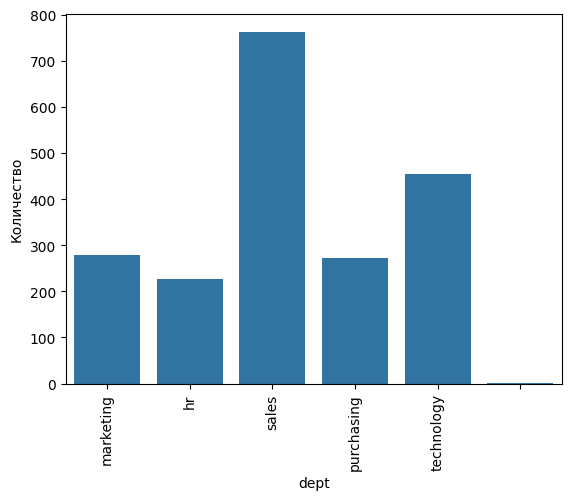

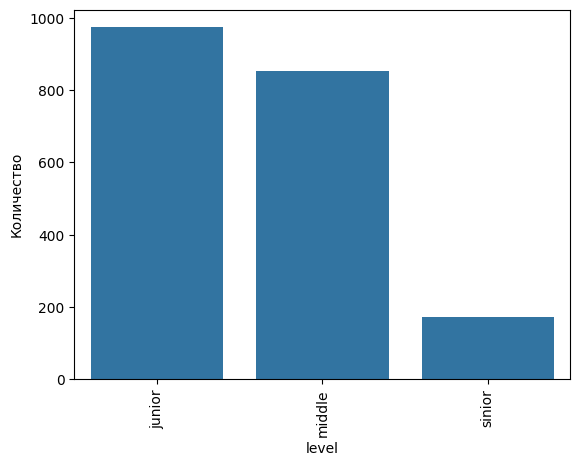

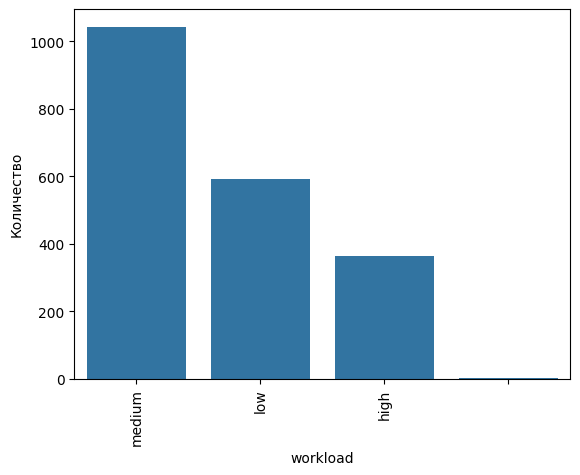

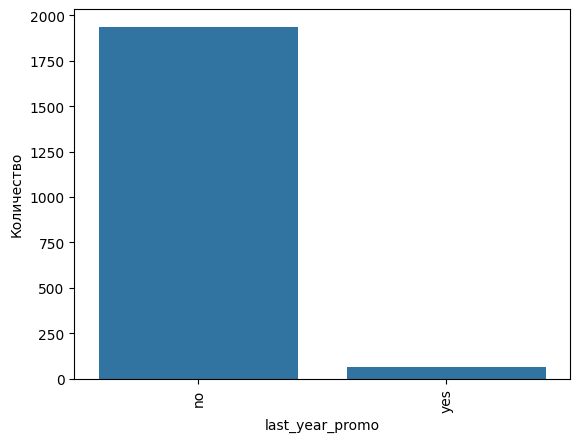

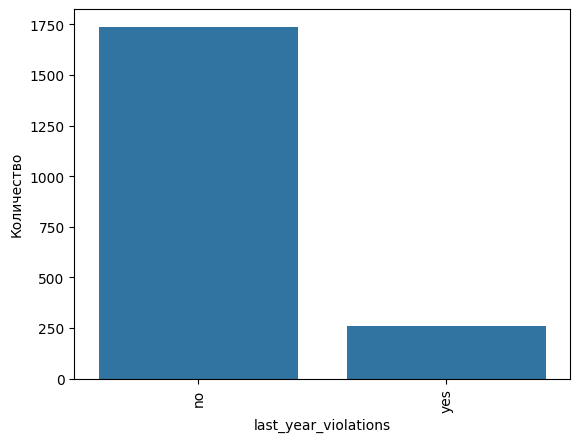

Гистограмма распределения значений для таблицы df_test_target_job_satisfaction_rate
Гистограмма распределения значений для таблицы df_train_quit


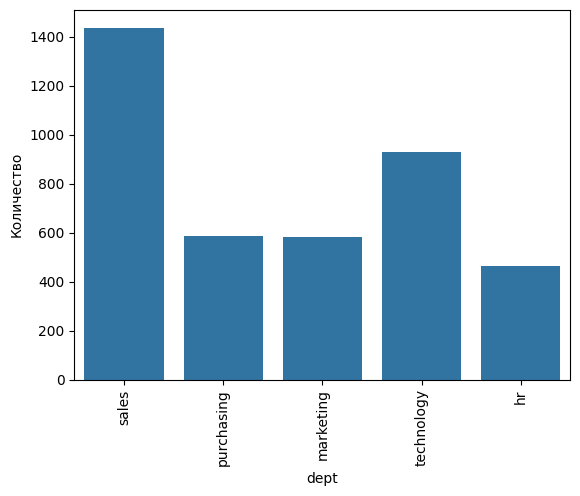

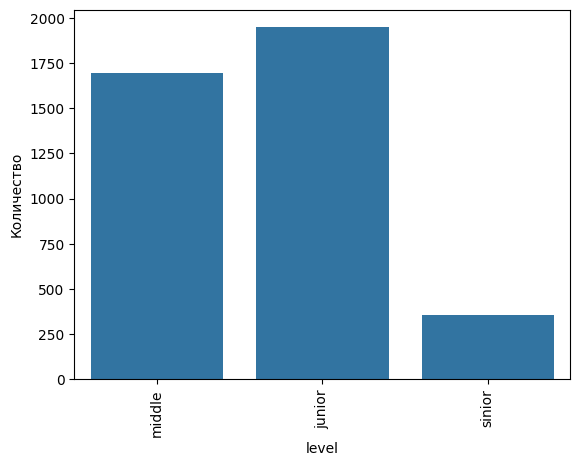

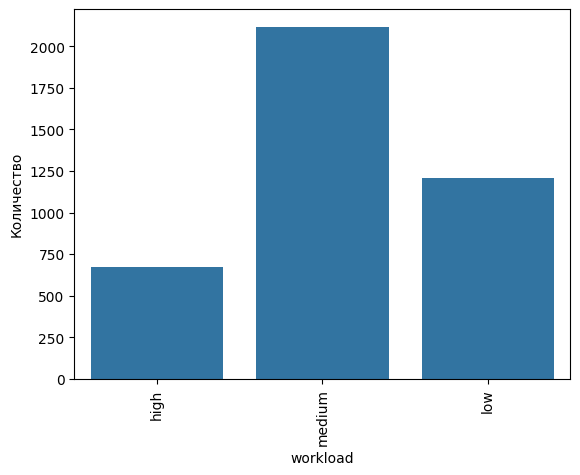

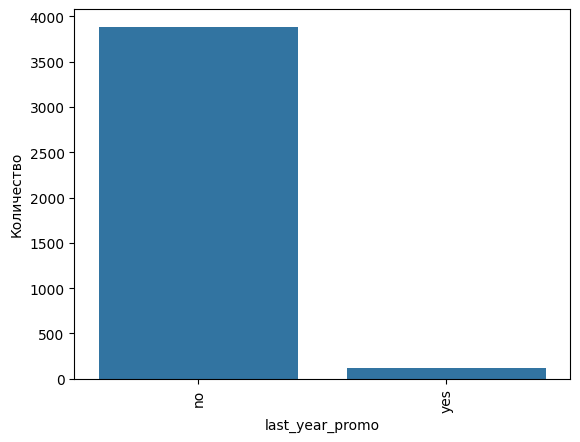

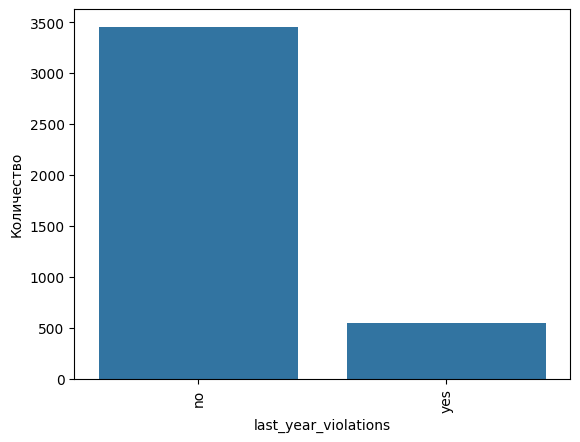

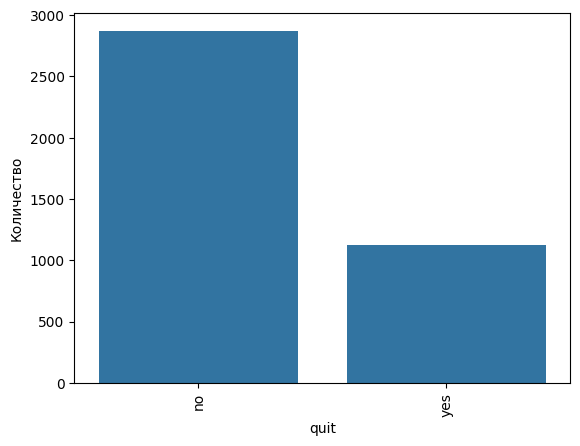

Гистограмма распределения значений для таблицы df_test_target_quit


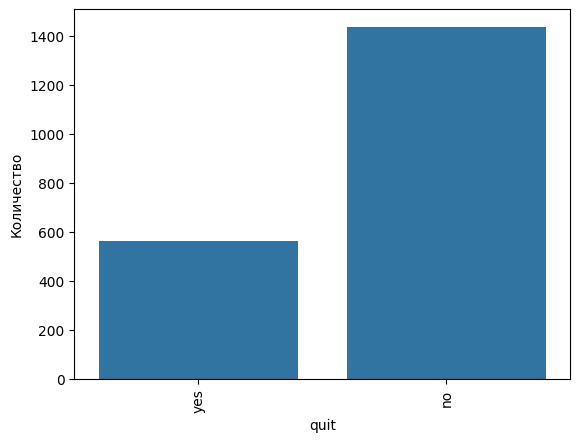

In [11]:
for f in DF_NAMES:
    print(f'Гистограмма распределения значений для таблицы {f}')
    for c in globals()['col_cat_' + f.strip('df_')]:
        ax = sns.countplot(x=c, data = globals()[f])
        ax.set(xlabel=c, ylabel='Количество')
        plt.xticks(rotation=90)
        plt.show()

По гистограммам можно сделать следующие наблюдения. Вцелом распределение данных поддается логике и ожидаемо. В наборе данных наблюдается сравнительно мизерное количество сотрудников с повышением ЗП. в таблице целевых признакам наблюдается дисбаланс признаков.

####  Построю для численных данных пару графиков гистограмму и ящик с усами, а заодно тест Колмогорова-Смирнова, чтобы получить нормальность распределения.

"Пара графиков для таблицы df_train_job_satisfaction_rate


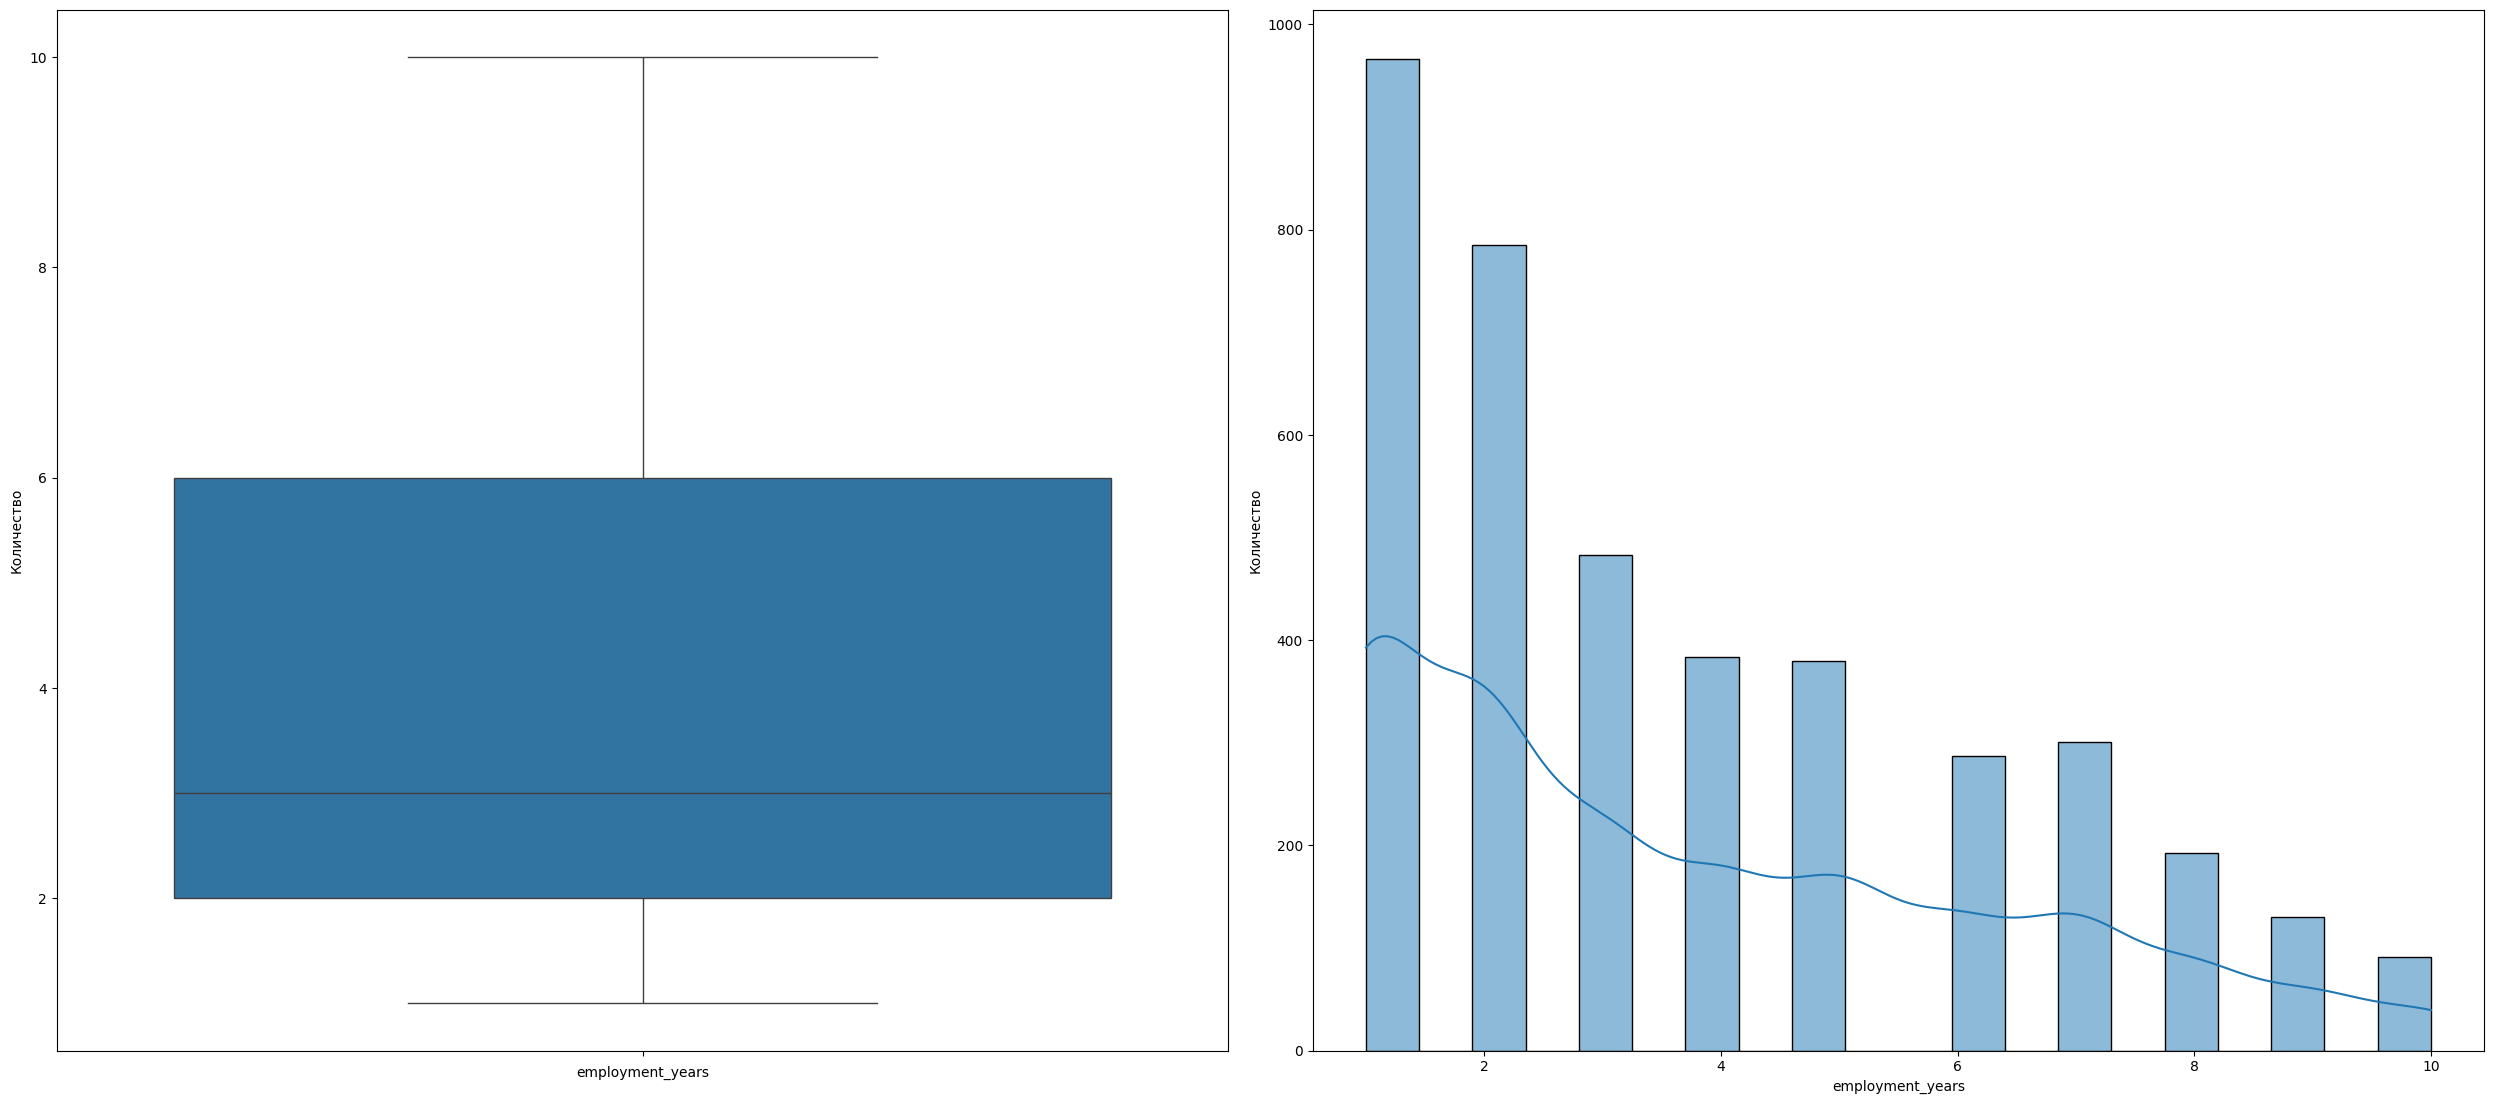

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


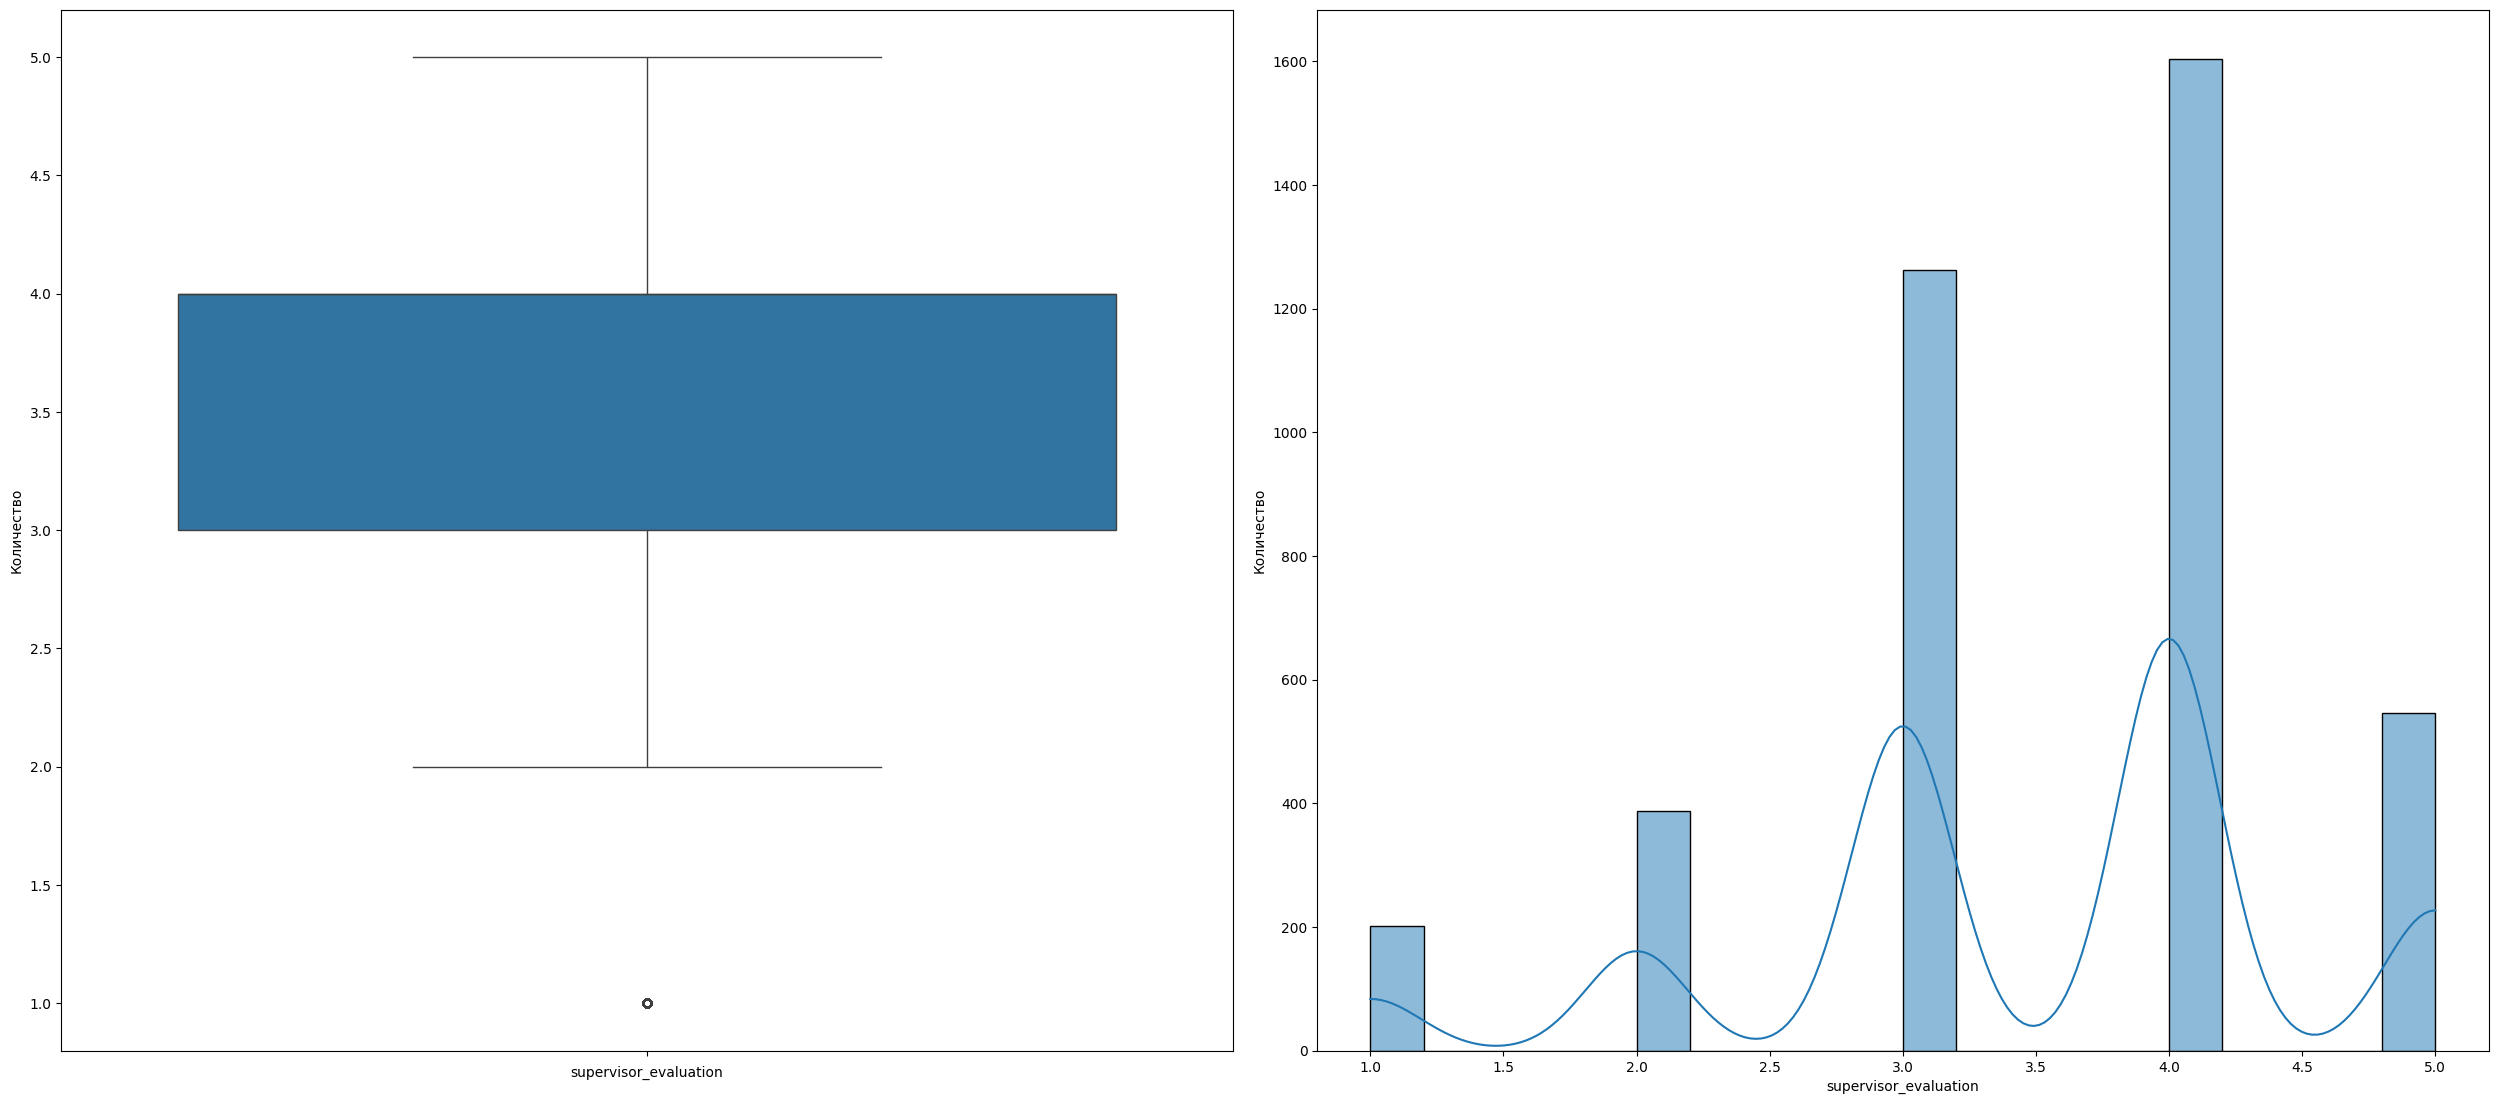

KstestResult(statistic=0.9269998680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


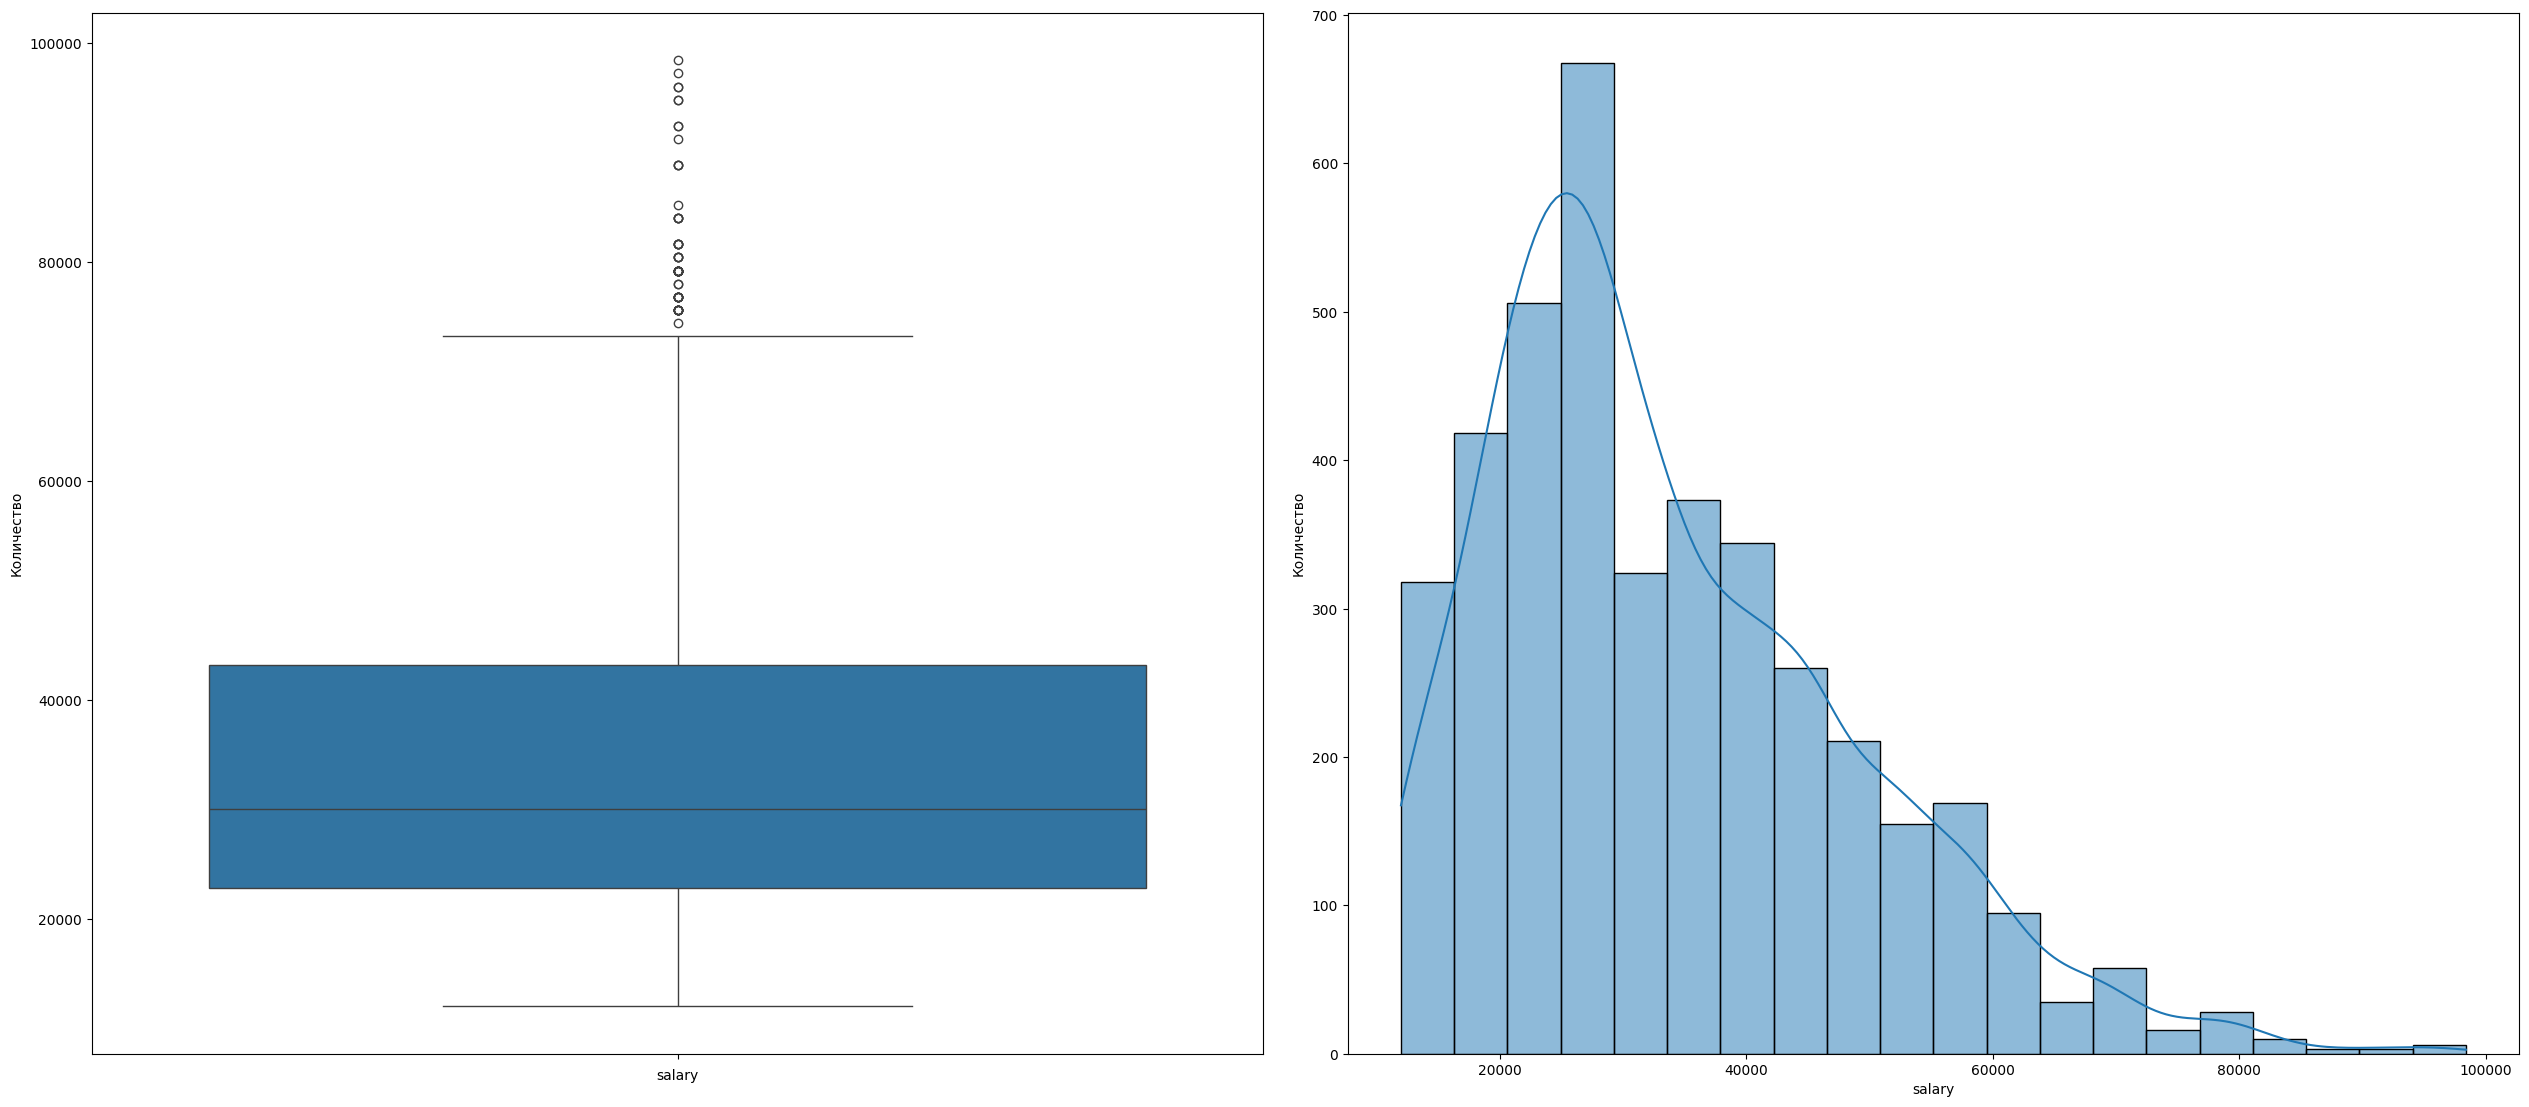

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)


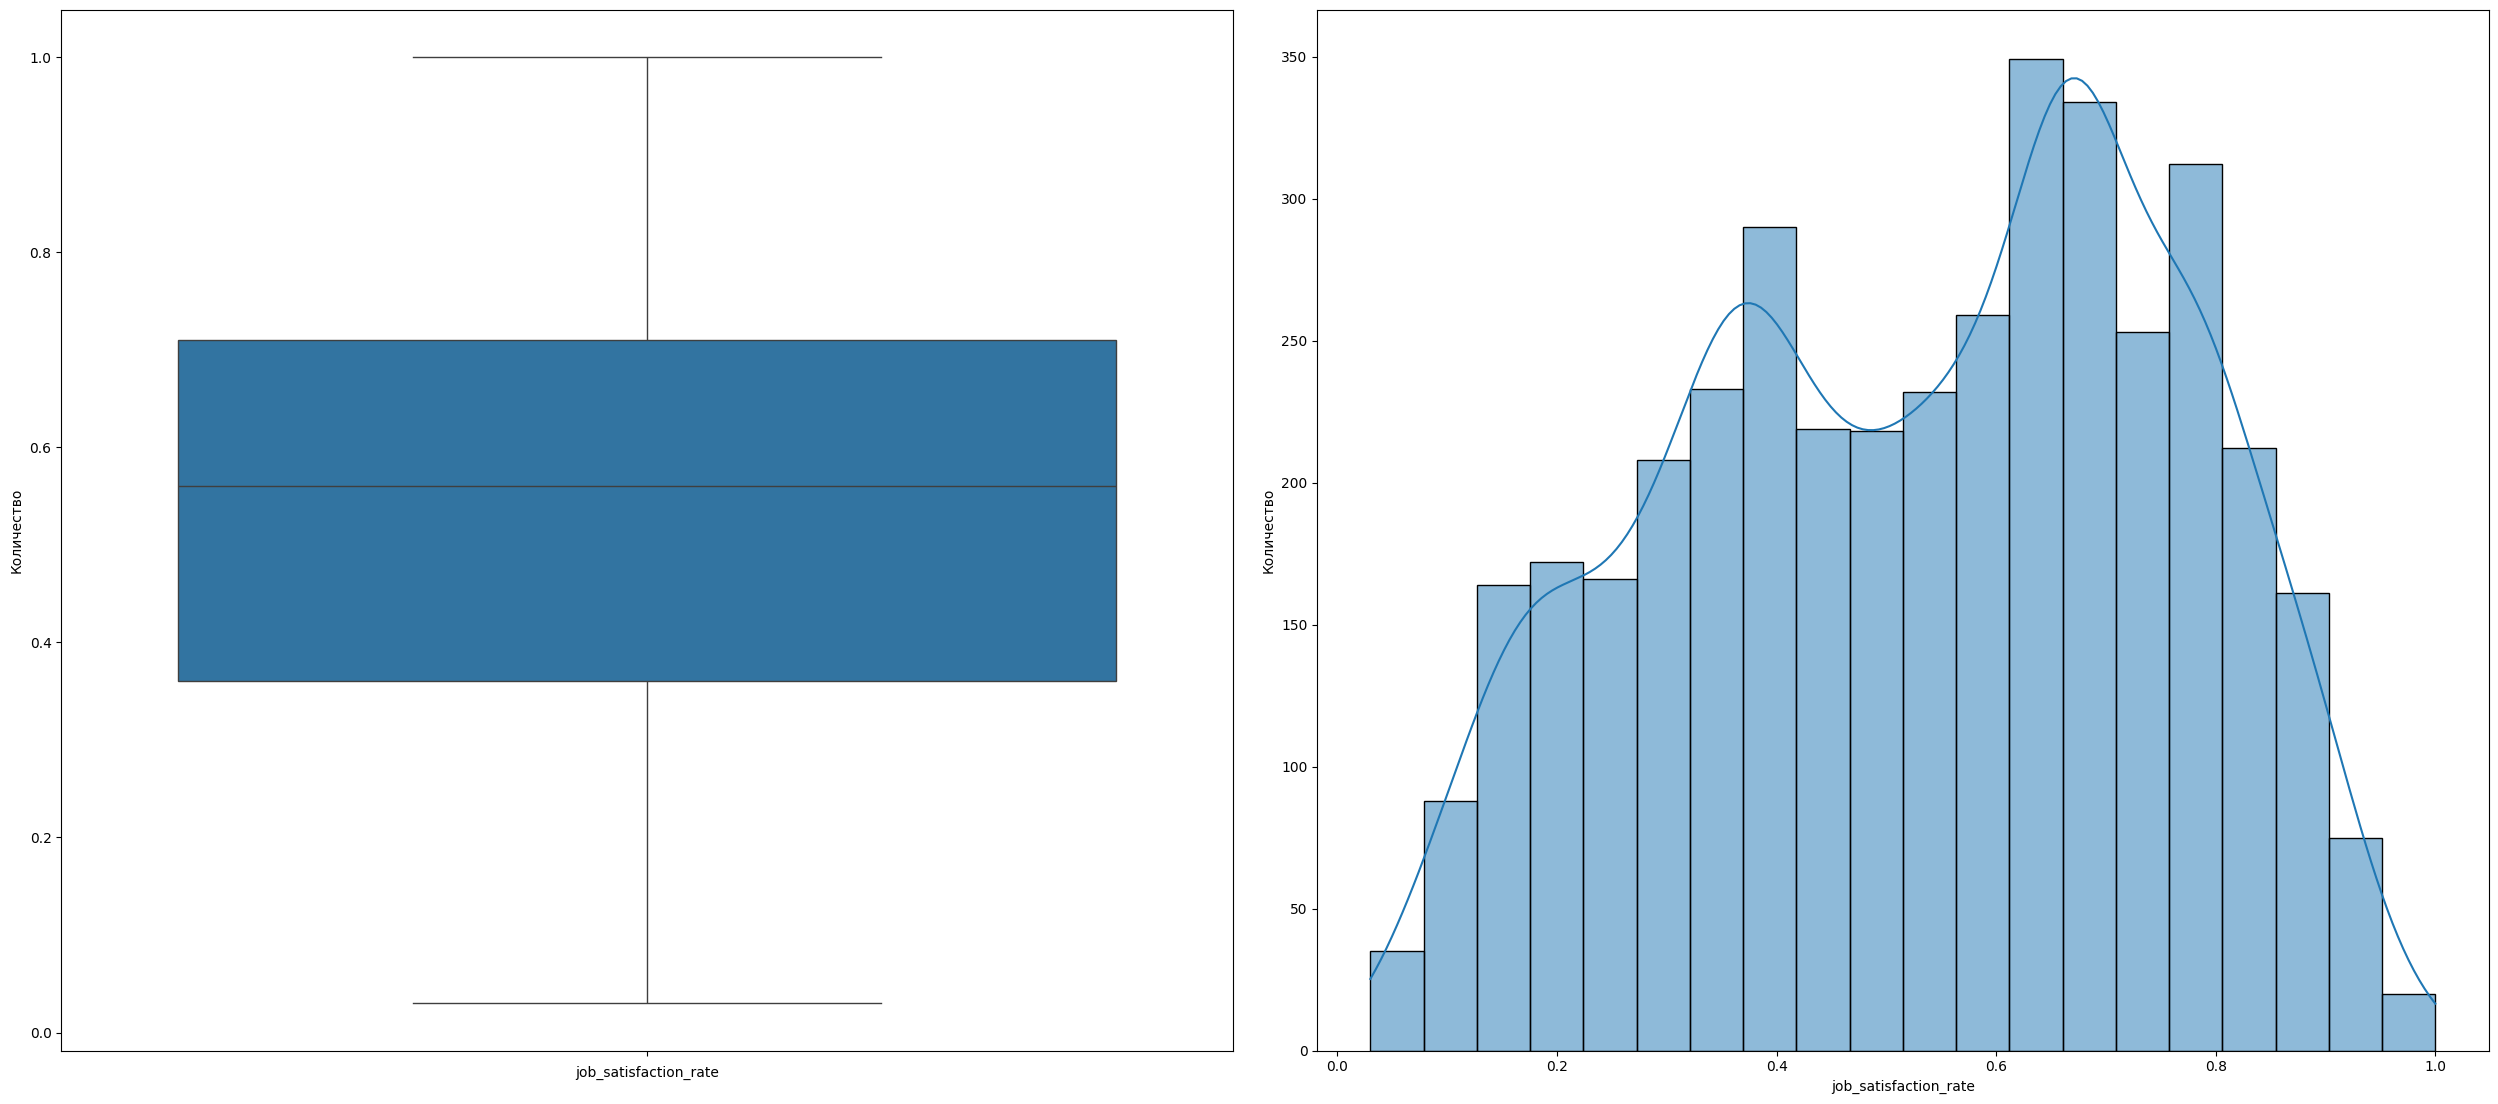

KstestResult(statistic=0.5241063925851721, pvalue=0.0, statistic_location=0.09, statistic_sign=-1)
"Пара графиков для таблицы df_test_features


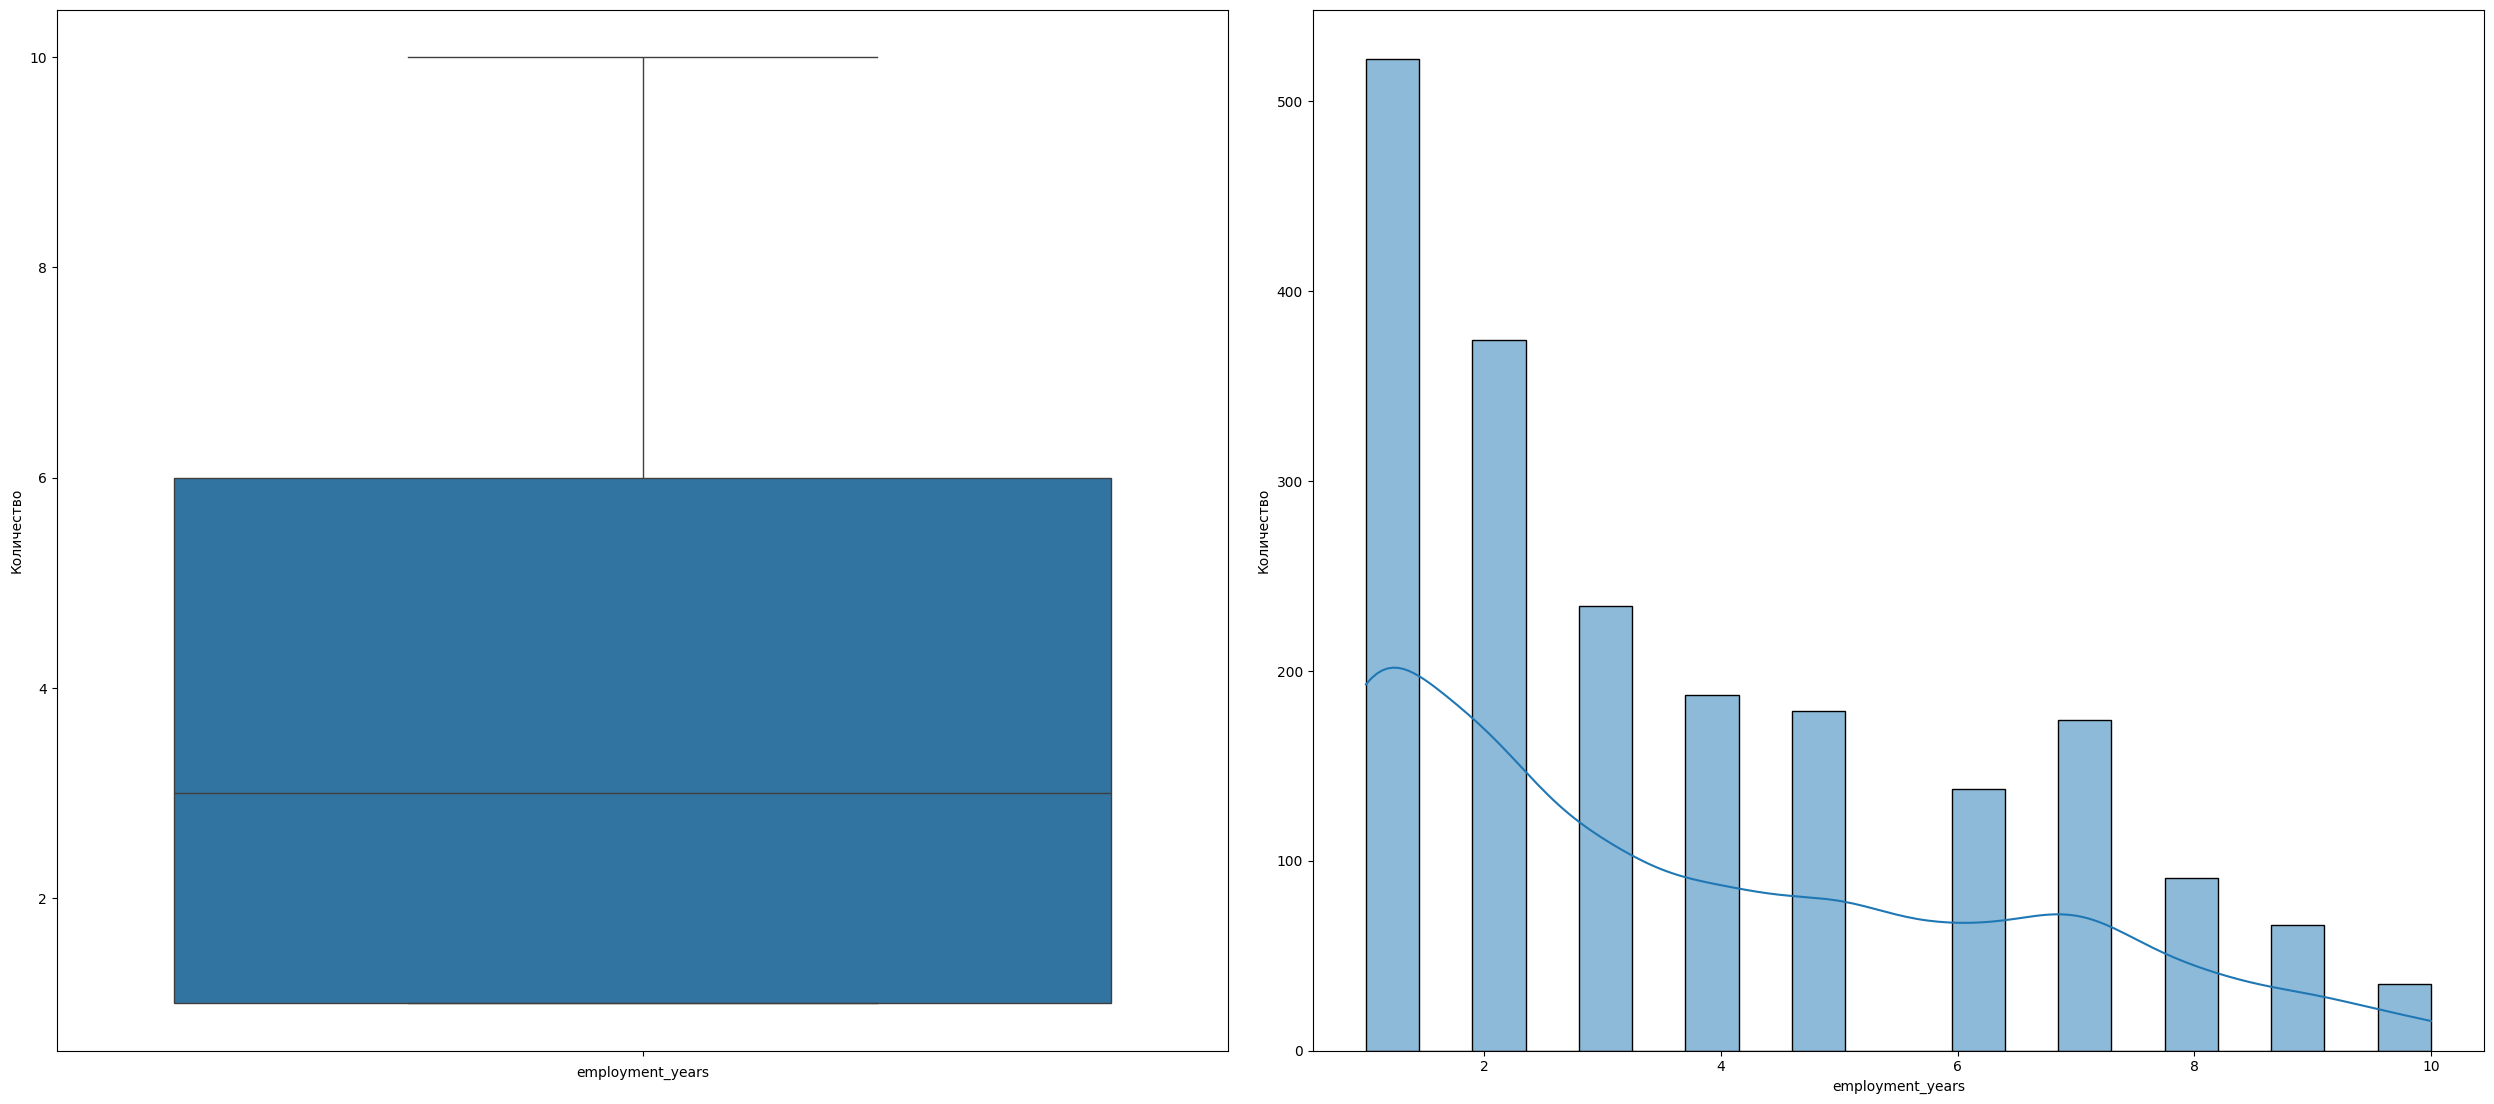

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


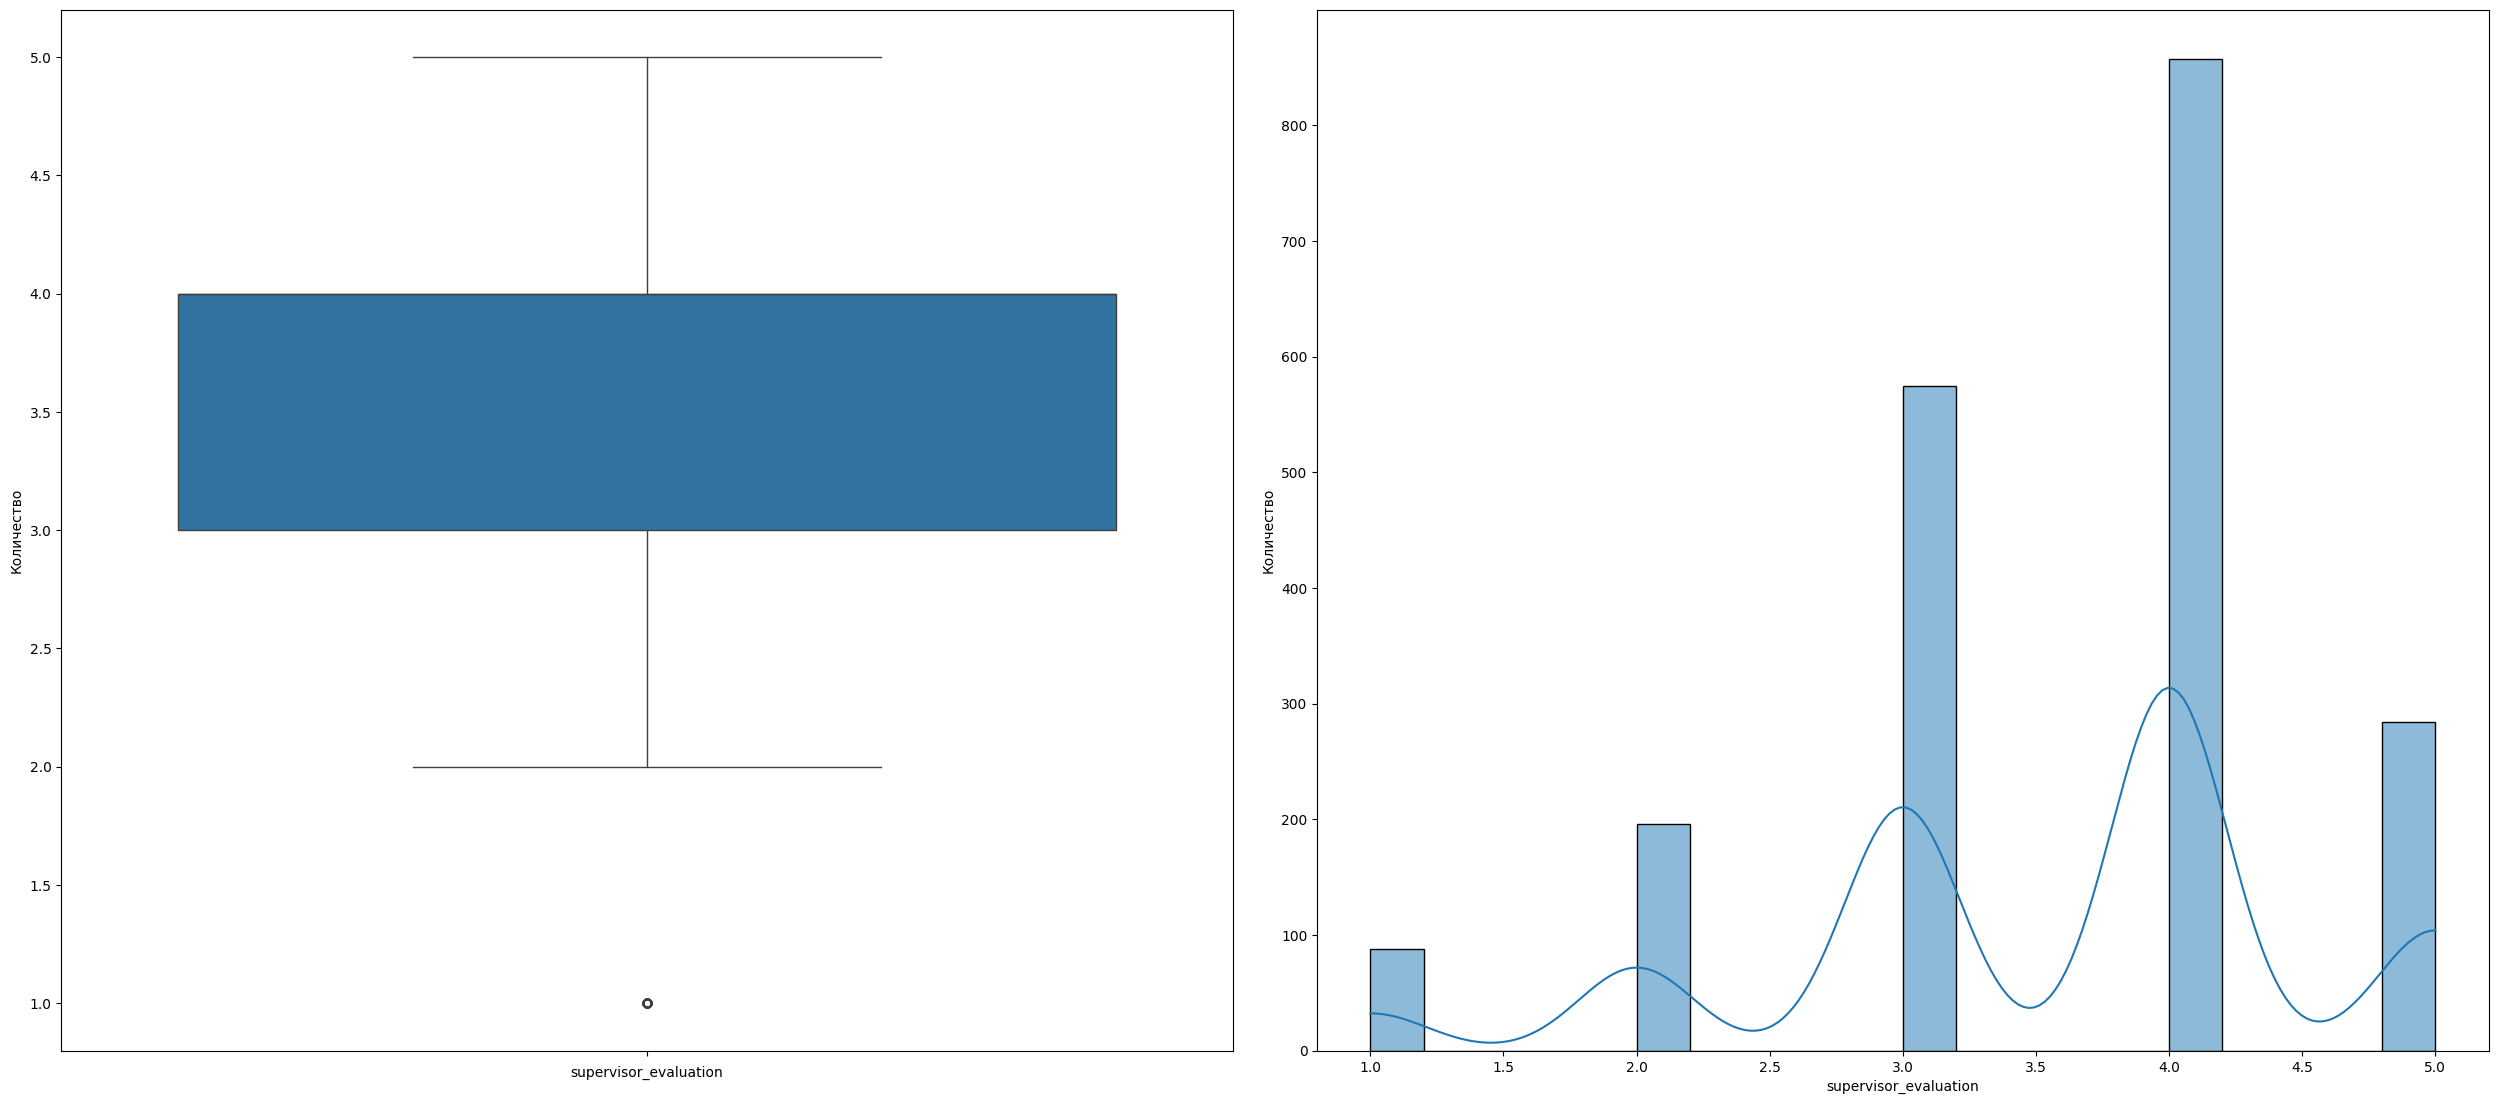

KstestResult(statistic=0.9332498680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


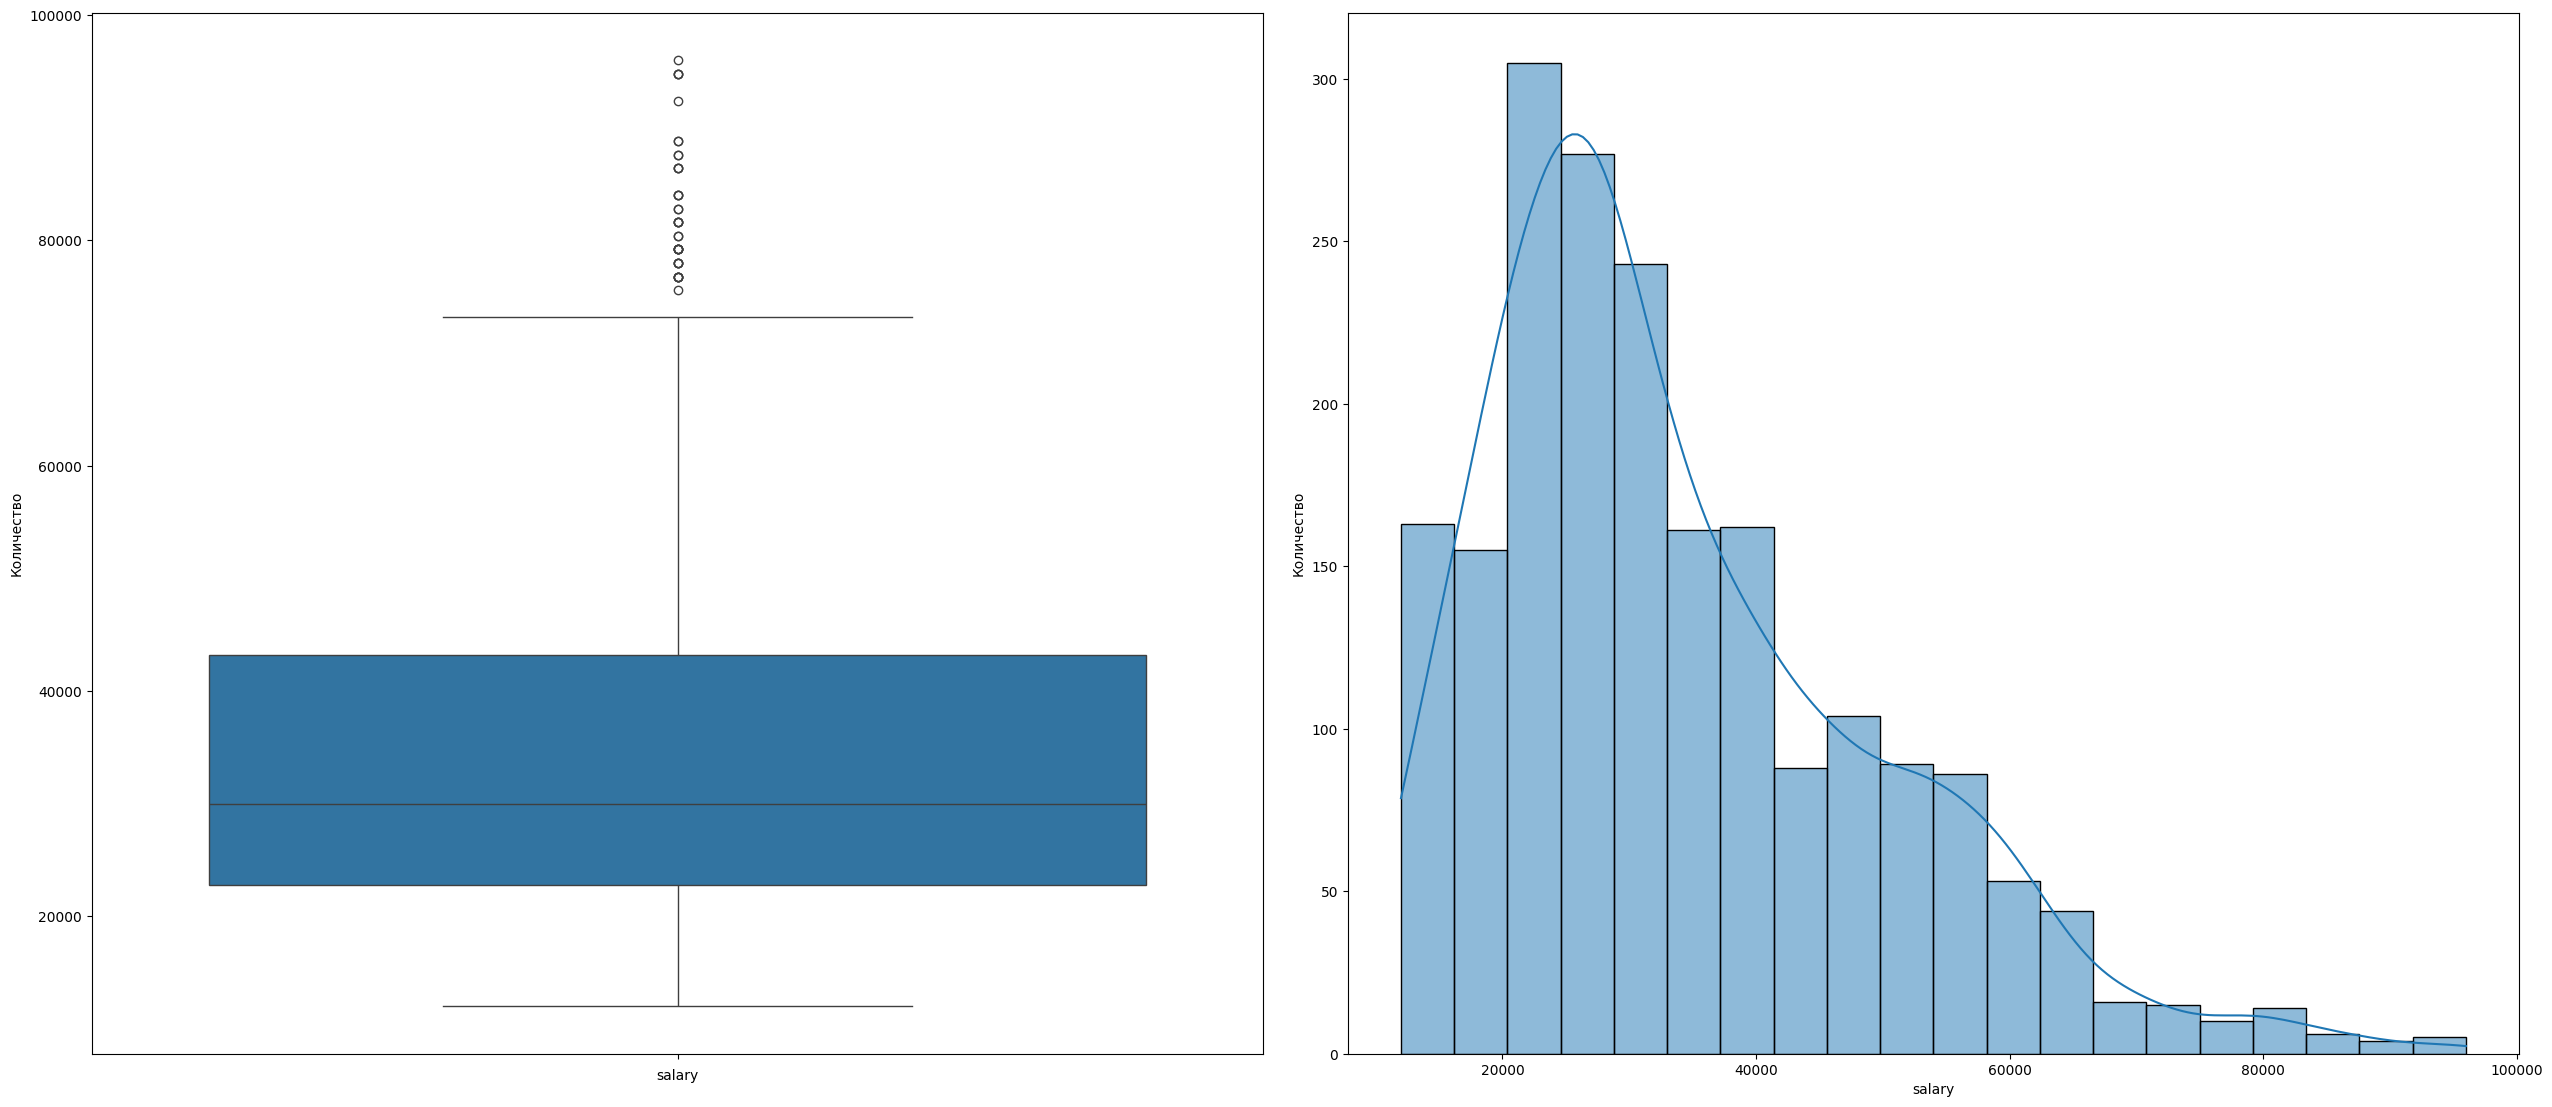

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)
"Пара графиков для таблицы df_test_target_job_satisfaction_rate


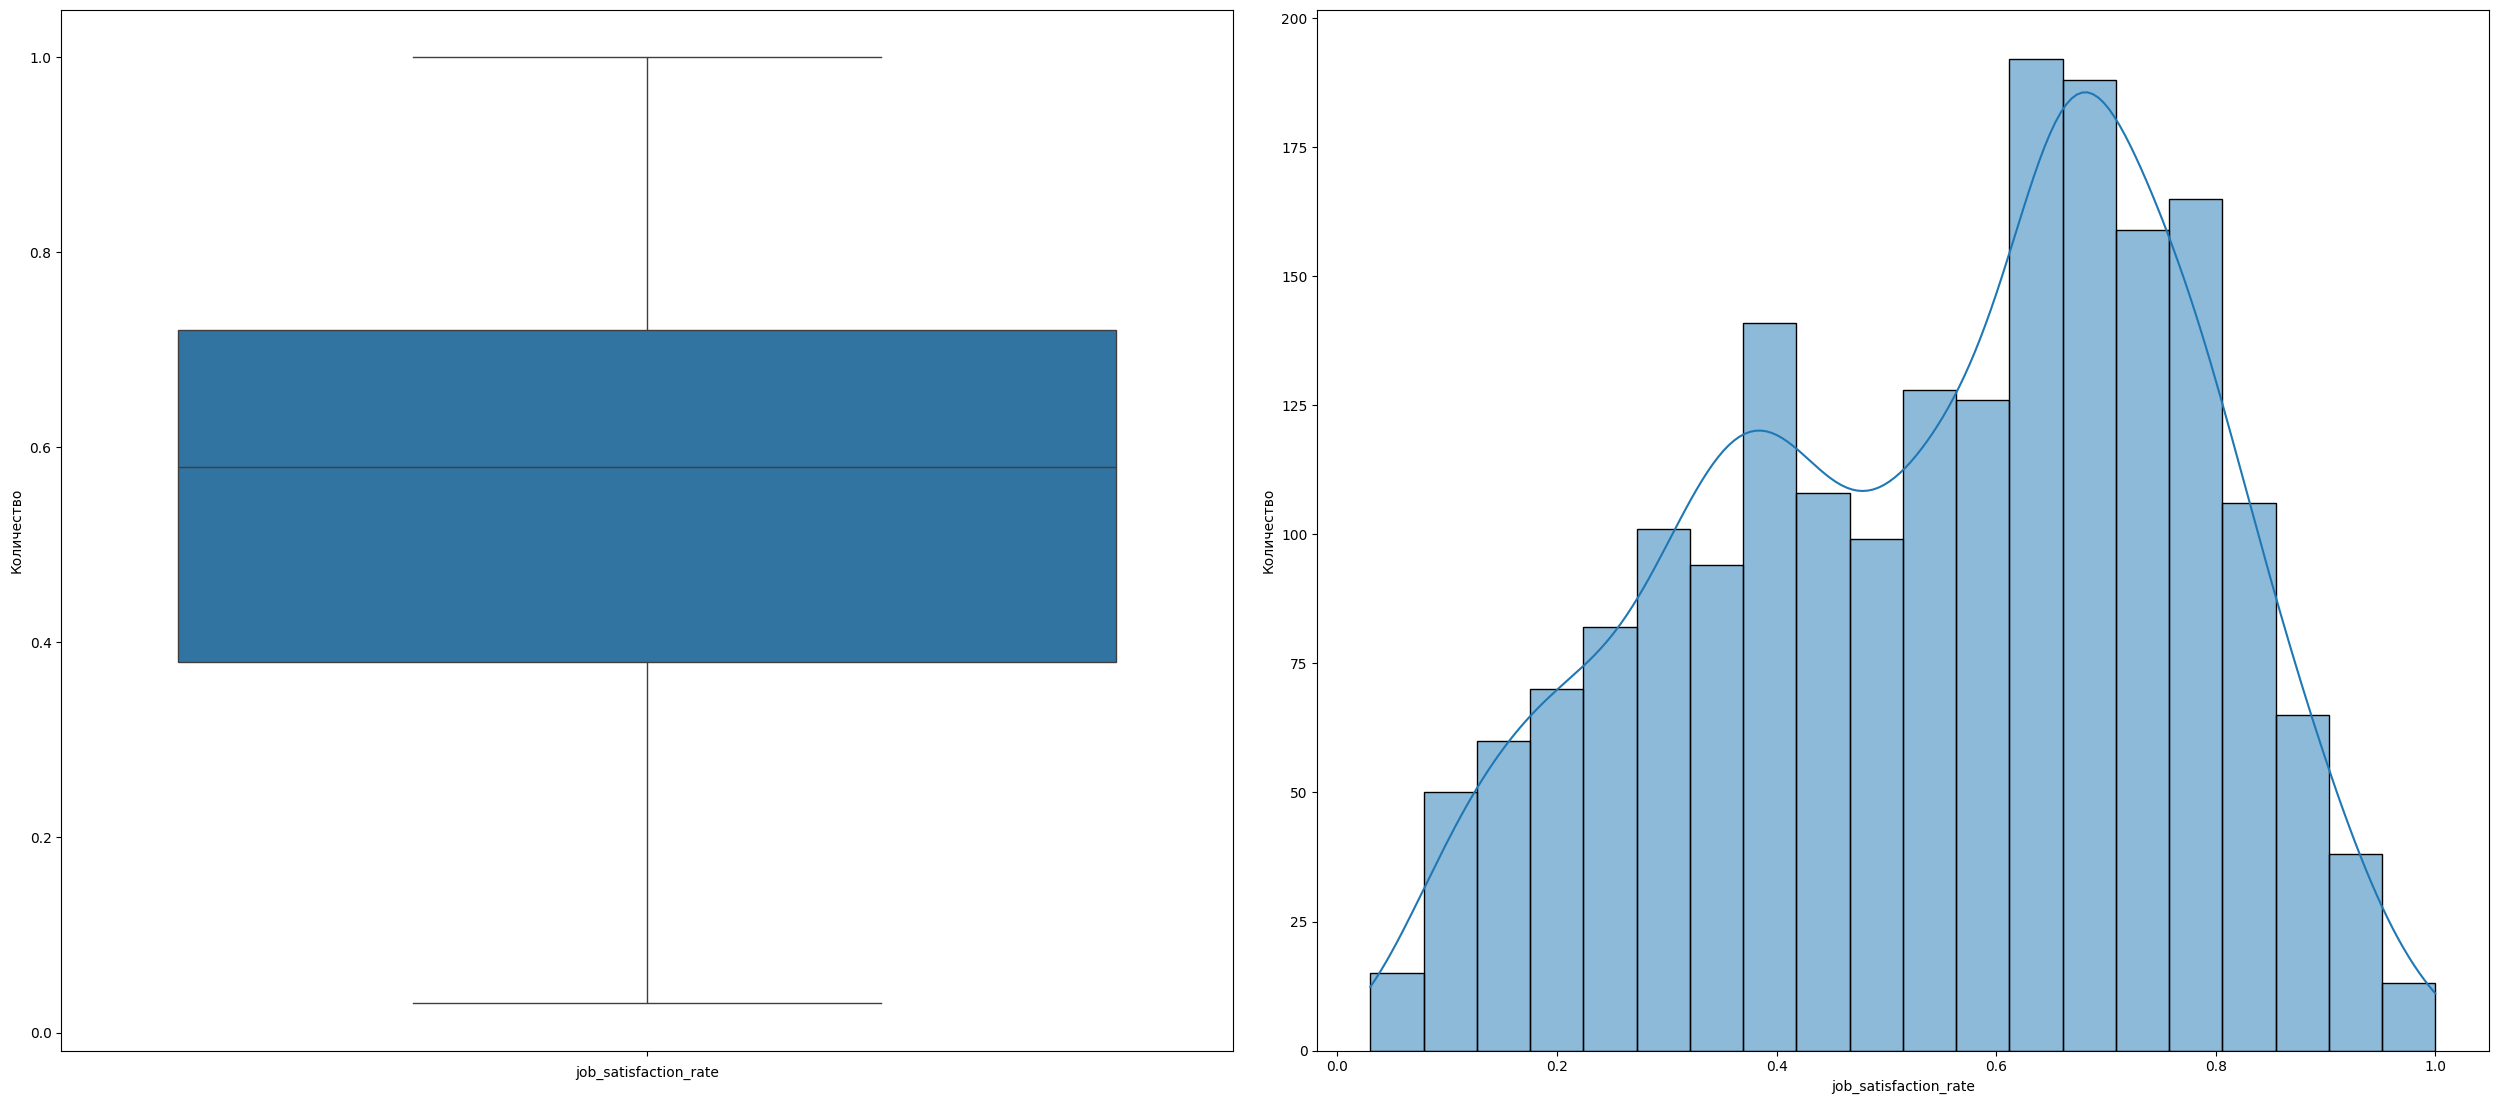

KstestResult(statistic=0.5263563925851722, pvalue=0.0, statistic_location=0.09, statistic_sign=-1)
"Пара графиков для таблицы df_train_quit


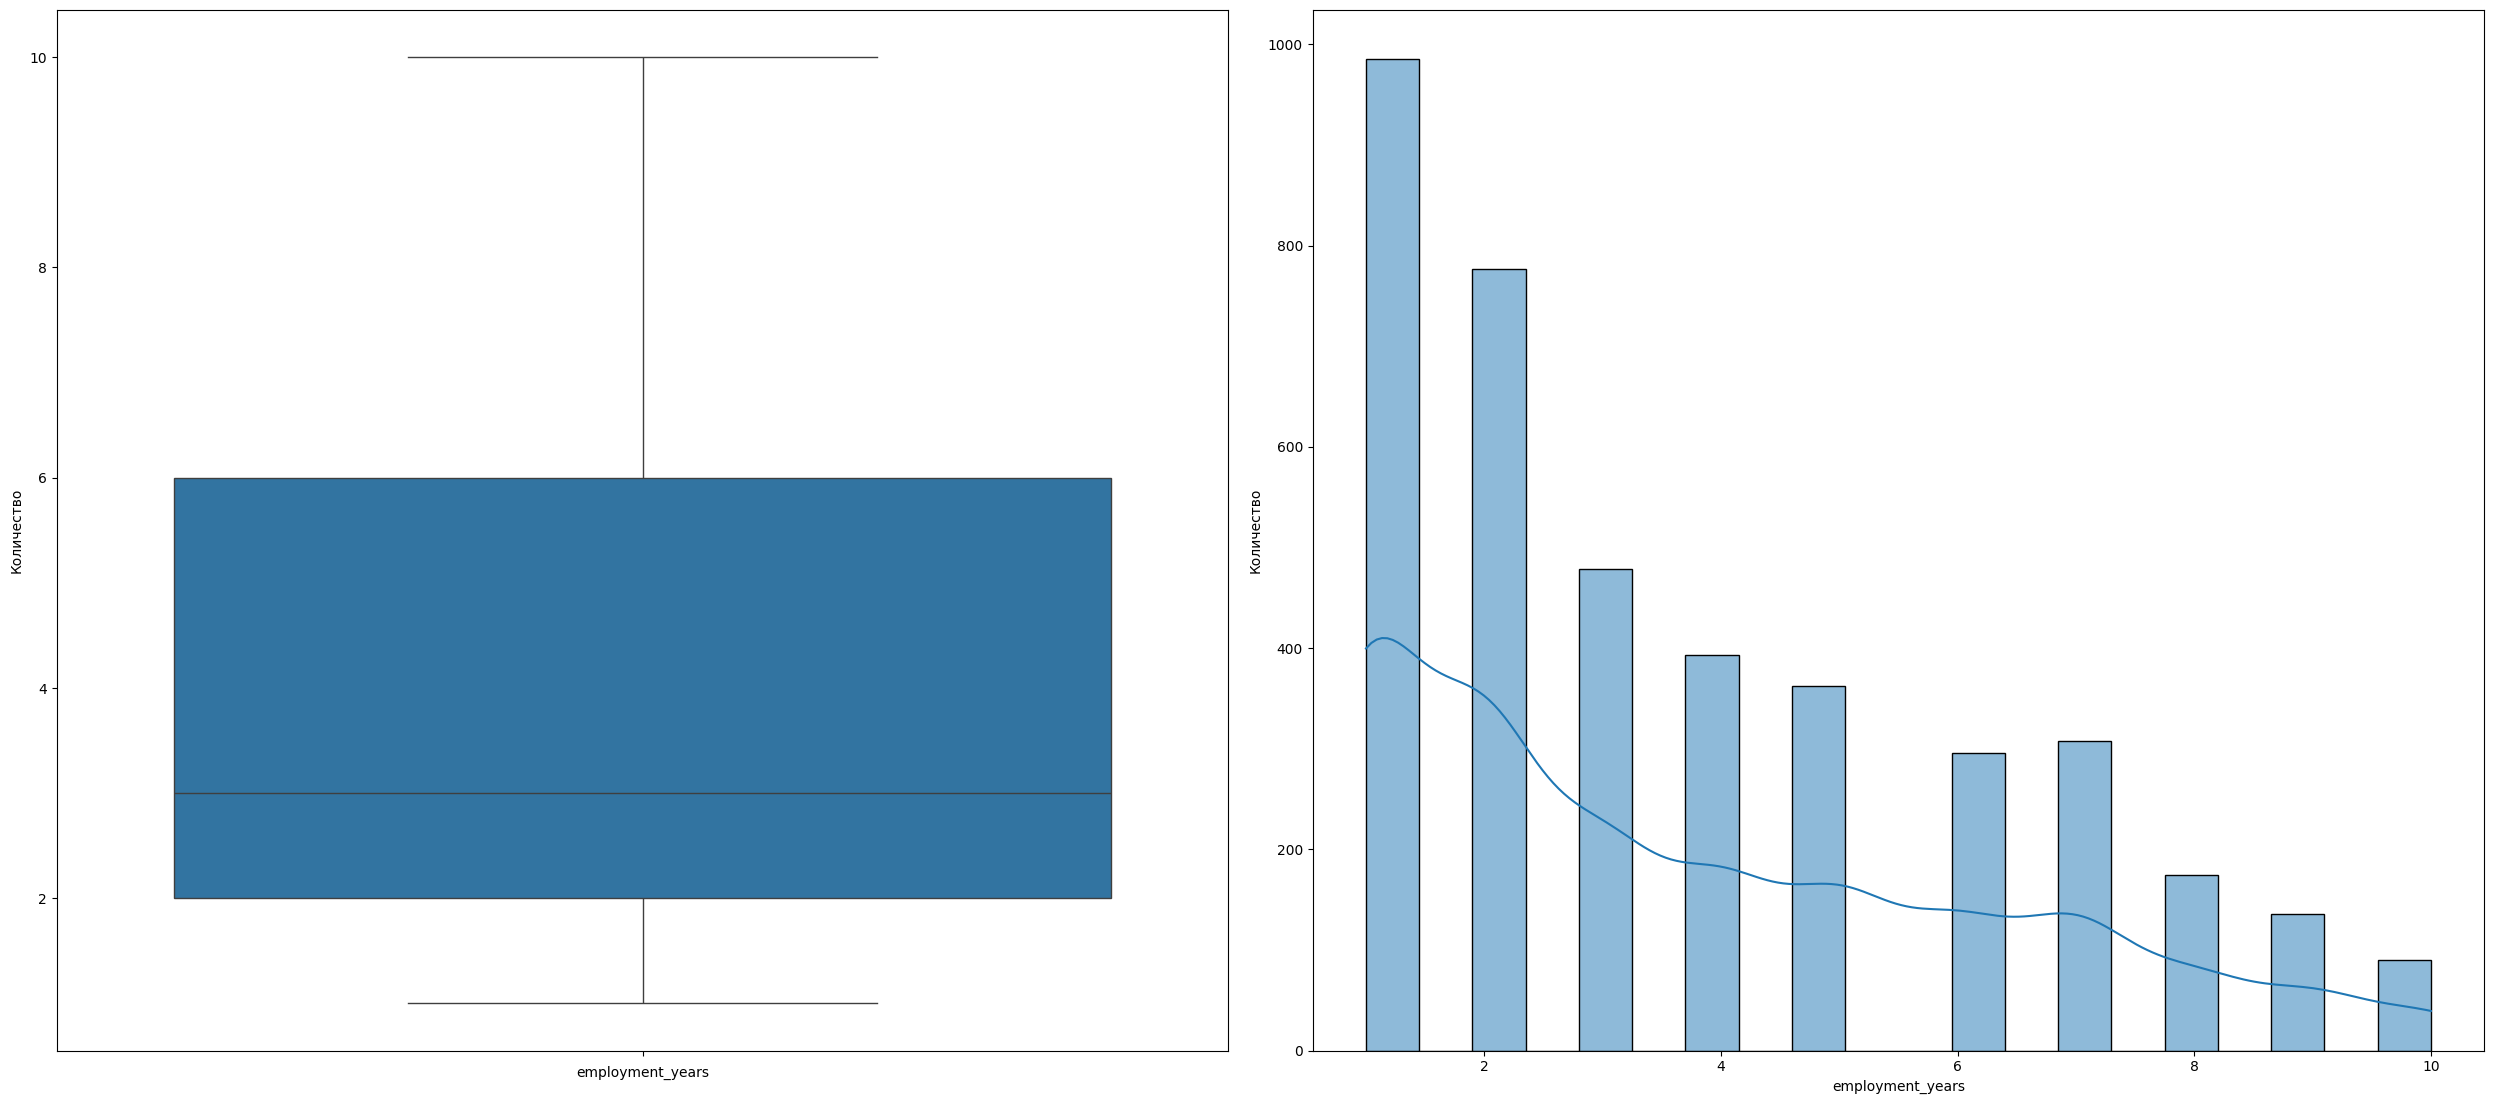

KstestResult(statistic=0.8413447460685429, pvalue=0.0, statistic_location=1, statistic_sign=-1)


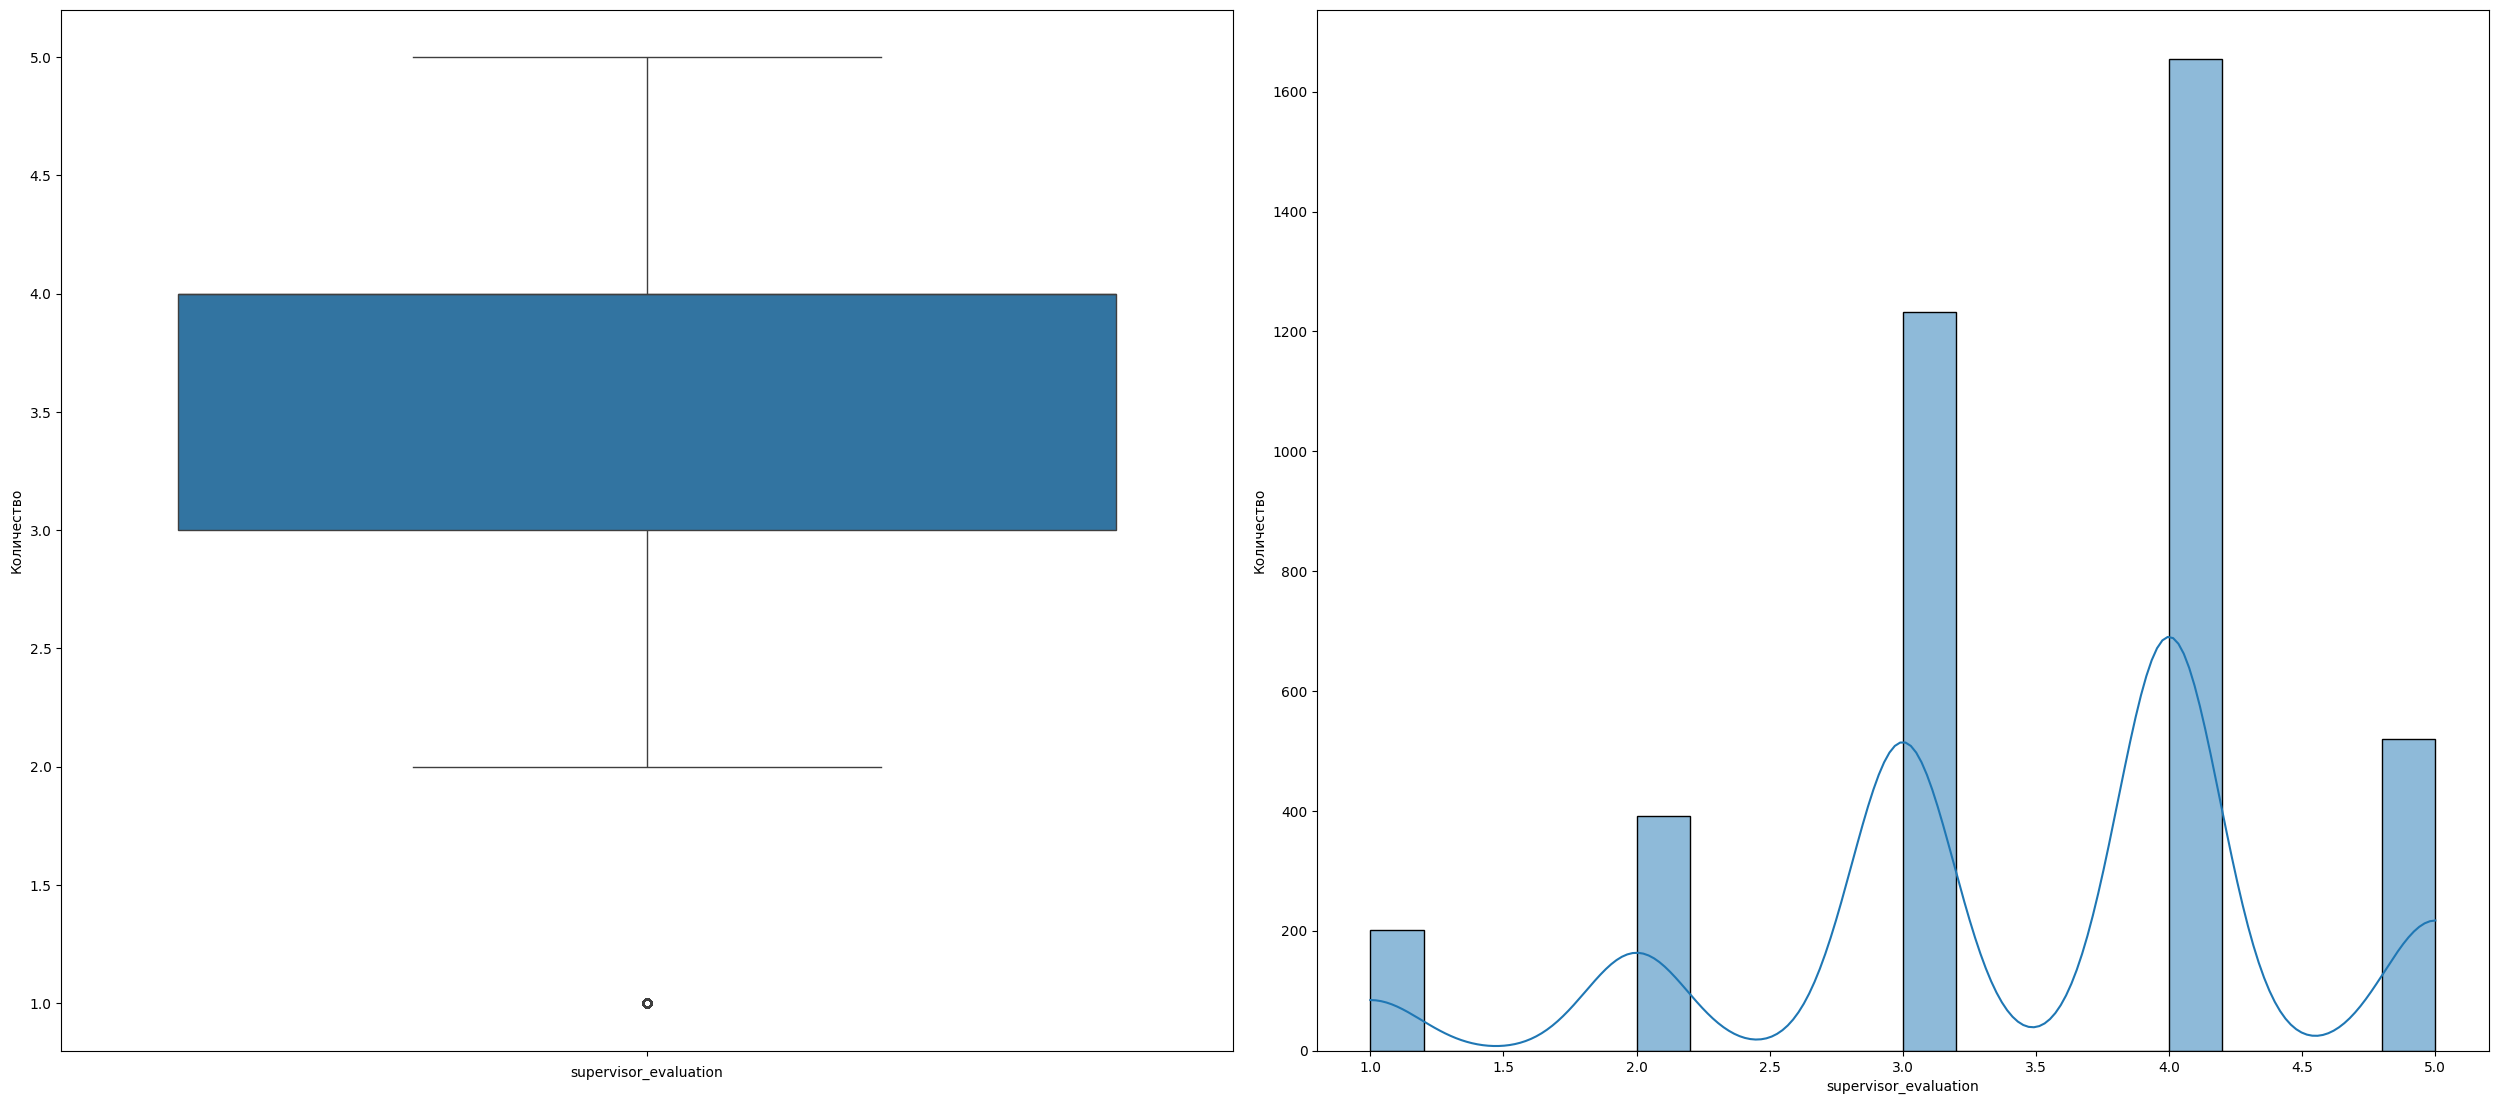

KstestResult(statistic=0.9267498680518208, pvalue=0.0, statistic_location=2, statistic_sign=-1)


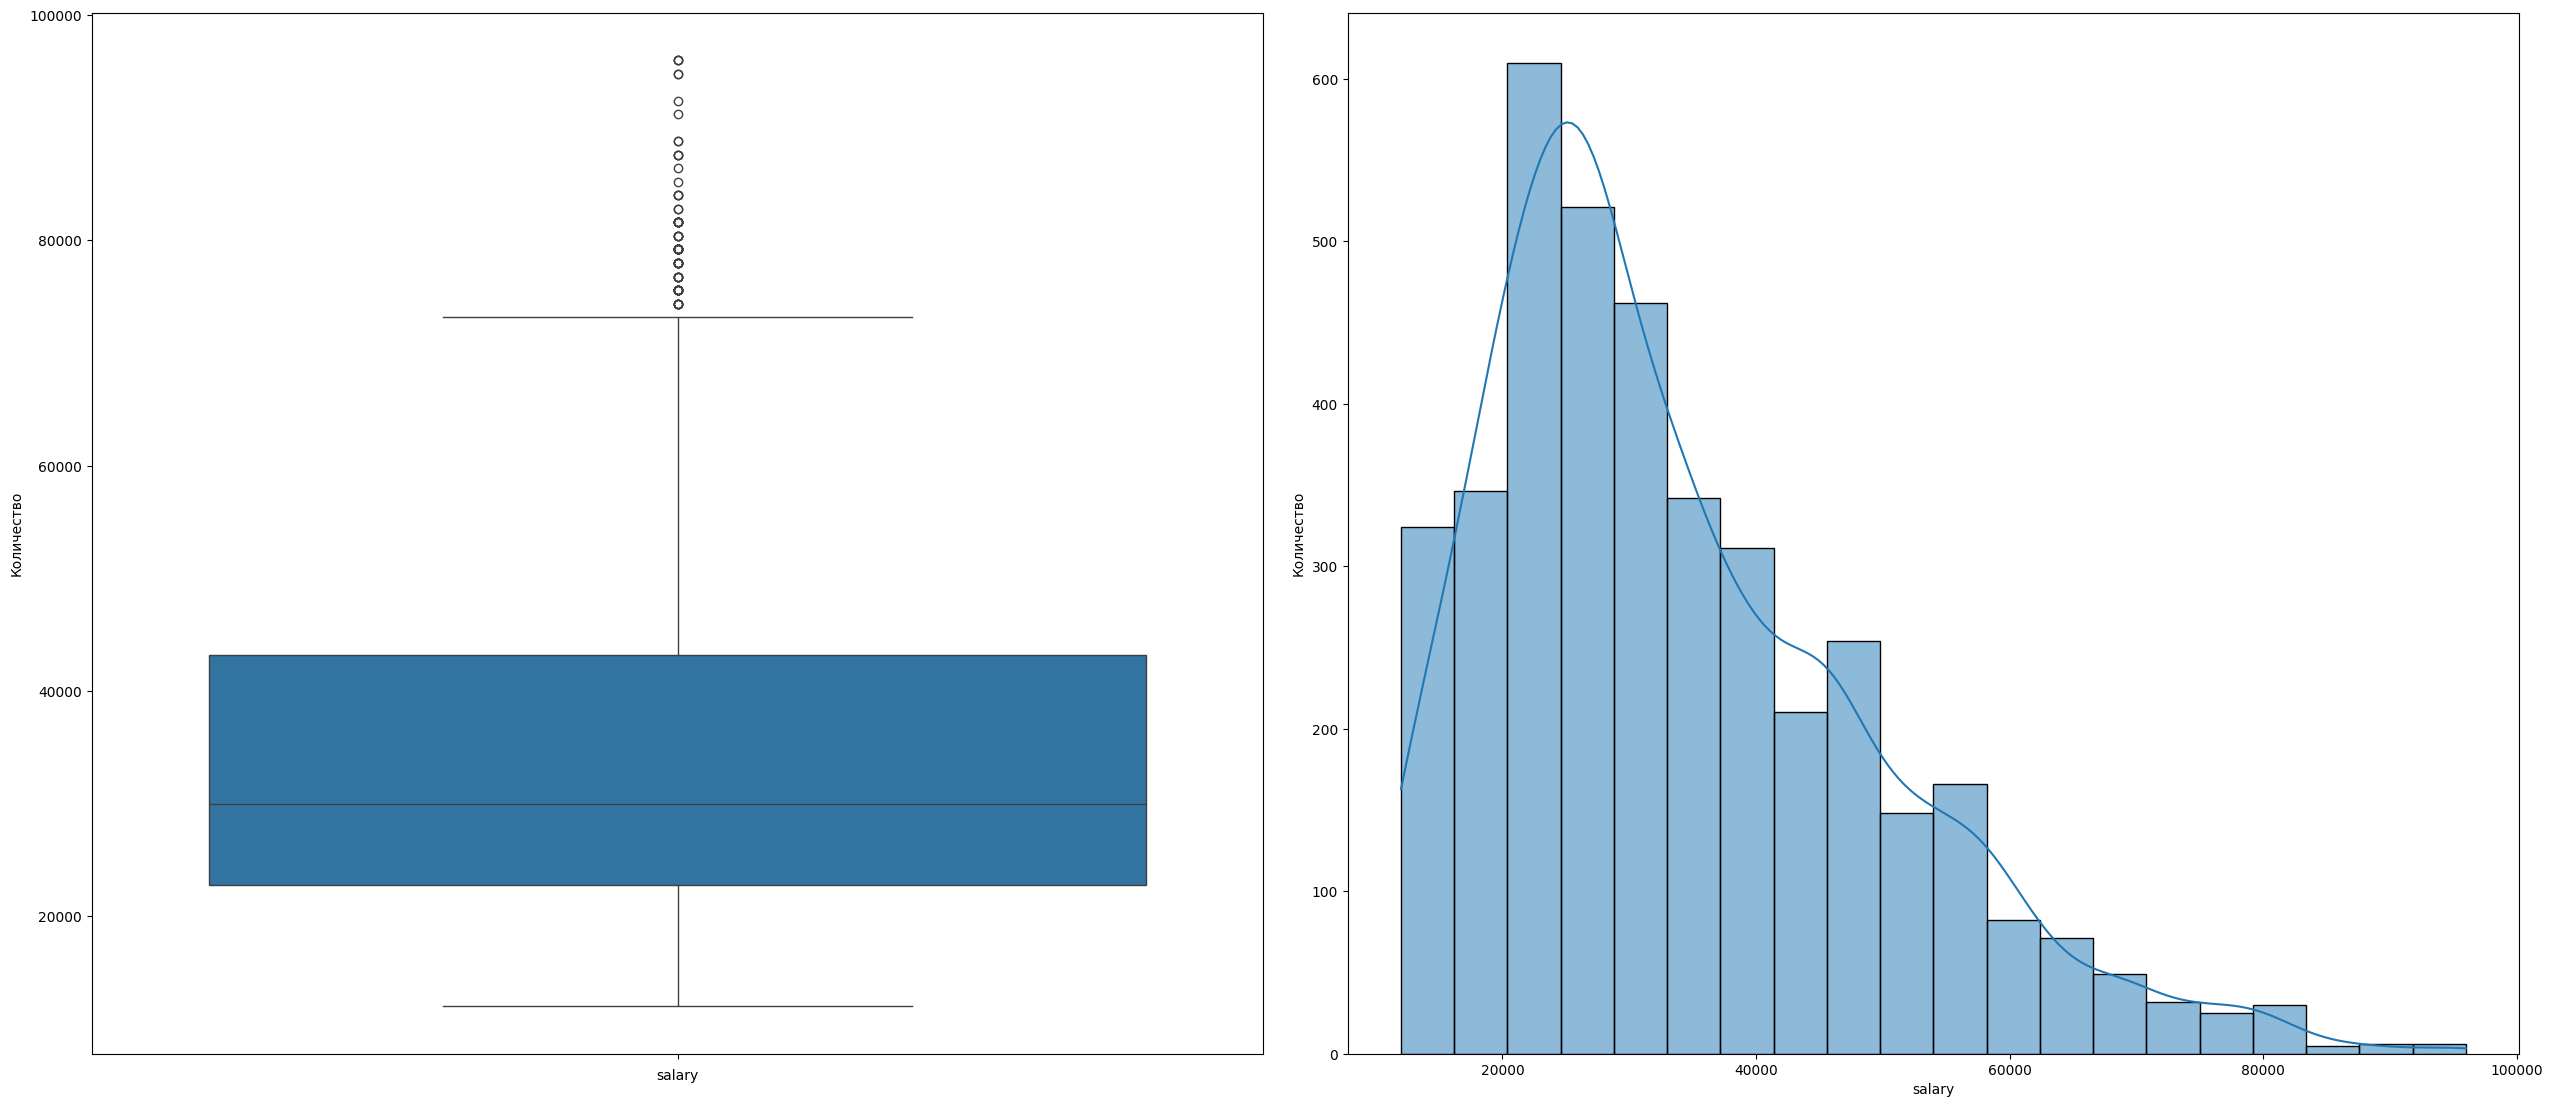

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=12000, statistic_sign=-1)
"Пара графиков для таблицы df_test_target_quit


In [12]:
for f in DF_NAMES[:5]:
    print(f'"Пара графиков для таблицы {f}')
    for c in globals()['col_num_' + f.strip('df_')]:
        if c != 'id':
            fig, axes = plt.subplots(1,2, figsize=(25, 11), constrained_layout=False)
            fig.tight_layout(h_pad=10,w_pad=3)
            axes = axes.ravel()
            ax = sns.boxplot(y=c, data=globals()[f], ax=axes[0])
            ax.set(xlabel=c, ylabel='Количество')
            ax = sns.histplot(x=c, data = globals()[f], bins=20, kde=True)
            ax.set(xlabel=c, ylabel='Количество')
            plt.show()
            print(kstest(globals()[f][c], 'norm'))

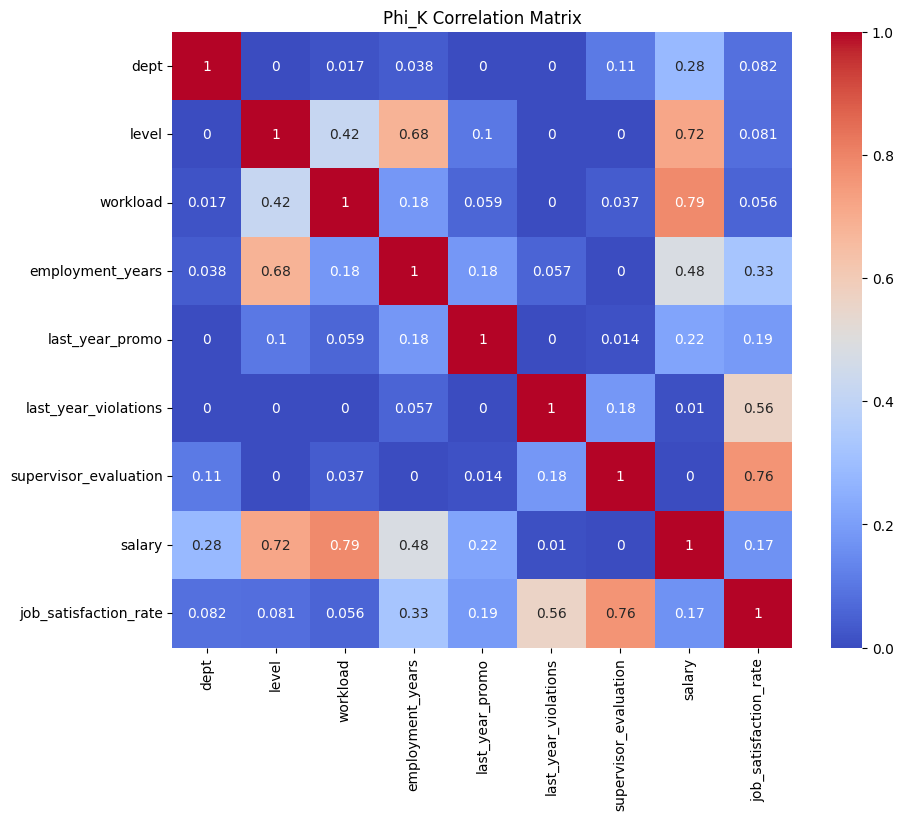

In [13]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = df_train_job_satisfaction_rate.phik_matrix(interval_cols= interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

В таблице ниже я опишу каждый признак, его категорию и подкатегорию.  

|  Имя признака  | Описание признака  | Тип признака  |  Подтип признака  |  
|:----|:----|:---:|:---:|
|  dept  |  отдел, в котором работает сотрудник  |  Категориальный  |  Номинальный  |  
|  level  |  уровень занимаемой должности  |  Категориальный  |  Порядковый  |  
|  workload  |  уровень загруженности сотрудника  |  Категориальный  |  Порядковый  |  
|  employment_years  |  длительность работы в компании (в годах)  |  Количественный  |  Дискретный  |  
|  last_year_promo  |  показывает, было ли повышение за последний год  |  Категориальный  |  Номинальный  |  
|  last_year_violations  |  показывает, нарушал ли сотрудник трудовой договор за последний год  |  Категориальный  |  Номинальный  |  
|  supervisor_evaluation  |  оценка качества работы сотрудника, которую дал руководитель  |  Количественный  |  Дискретный  |  
|  salary  |  ежемесячная зарплата сотрудника  |  Количественный  |  Непрерывный  |  
|  job_satisfaction_rate  |  уровень удовлетворённости сотрудника работой в компании, целевой признак  |  Количественный  |  Непрерывный  |  

Выводом станет распределение имен колонок по спискам в константах, которые будут в дальнейшем использованы в паплайнах.

In [14]:
OHE_COLUMNS = ['dept']
ORD_COLUMNS = ['level', 'workload']
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary']
BIN_COLUMNS = ['last_year_promo', 'last_year_violations']

#### Построю диаграмму рассеяния для зависимости целевого признака от признаков.

The figure layout has changed to tight


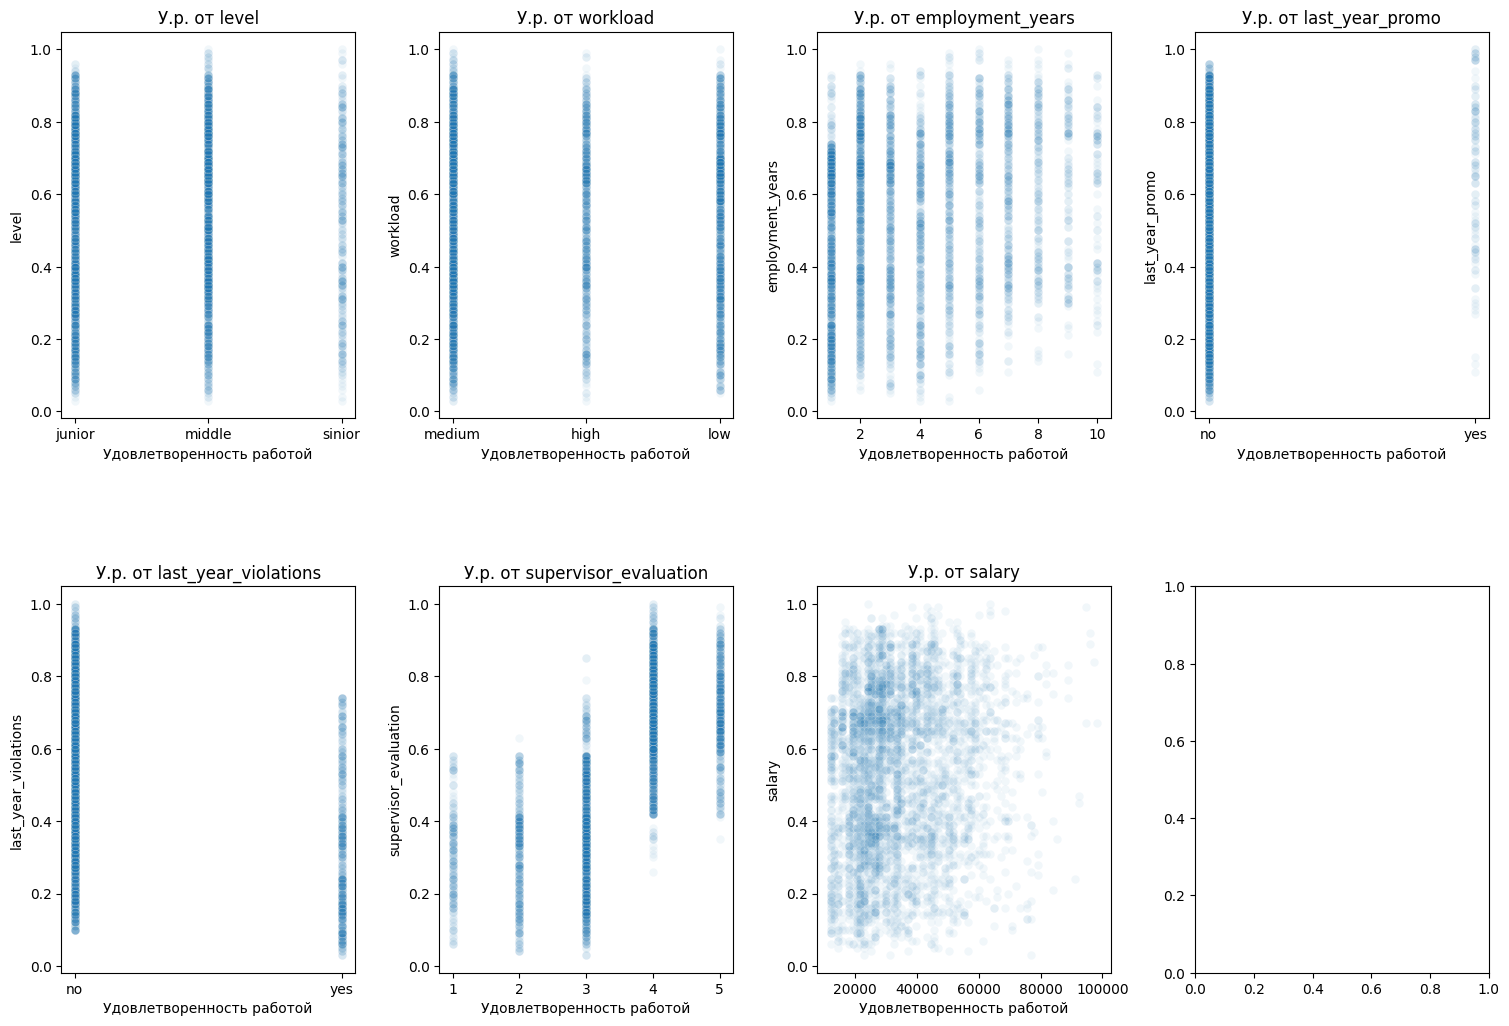

In [15]:
x=0
fig, axes = plt.subplots(2,4, figsize=(15, 10), constrained_layout=True)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()
for col in df_train_job_satisfaction_rate.columns.to_list()[1:-1]:
    ax = sns.scatterplot(data=df_train_job_satisfaction_rate, y='job_satisfaction_rate', x=col, ax=axes[x], alpha=0.06)
    ax.set(xlabel='Удовлетворенность работой', ylabel=col, title=('У.р. от ' + col))
    x+=1

<a id='t004'></a>  
#  4. Подготовка данных

### Исправлю порядок в тестовых данных

In [16]:
df_test_features = df_test_features.merge(df_test_target_job_satisfaction_rate, how = 'left', on='id')
display(df_test_features)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56
109582,technology,middle,low,3,no,no,2,21600,0.14
305653,technology,junior,low,1,no,no,3,14400,0.11


### Объявлю конвеер для OneHotEncoder

In [17]:
r_o_s = RandomOverSampler(random_state = RANDOM_STATE)

In [18]:
bin_pipe = Pipeline([
    ('simpleImputer_bin', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

In [19]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]) 

Объявлю конвеер для OrdinalEncoder

In [20]:
ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],], 
                            handle_unknown='use_encoded_value', 
                            unknown_value=np.nan
            )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Собираю все вместе и добавляю обработку численных признаков MinMaxScaler'ом

In [21]:
data_preprocessor = ColumnTransformer(
    [
        ('num', MinMaxScaler(), NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
        ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
    ], 
    remainder='passthrough'
) 

<a id='t005'></a>  
#  5. Обучение моделей

Объявлю метрику из заранее созданной функции

In [22]:
smape_score = make_scorer(smape, greater_is_better=False)

Объявлю словарь гиперпараметров моделей

In [23]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300), 
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Итоговый паплайн

In [24]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Определю автоматический поиск моделей через RandomizedSearchCV

In [25]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Выделю из тренировочной выбоки целевые признаки

In [26]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis = 1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']
X_test = df_test_features.drop(['job_satisfaction_rate'], axis = 1)
y_test = df_test_features['job_satisfaction_rate']

In [27]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('simpleImputer_bin',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [28]:
#print("\n Лучшая модель:\n", randomized_search.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(-randomized_search.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {randomized_search.best_params_}')
#pred = randomized_search.predict(X_test)
print(f'\n Метрика SMAPE на тестовой выборке: {smape(y_test, randomized_search.predict(X_test)):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 14.18

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 263, 'models__max_depth': 134, 'models': DecisionTreeRegressor(random_state=42)}

 Метрика SMAPE на тестовой выборке: 13.43


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


<a id='t006'></a>  
#  6. Вывод Задачи-1

Лучшей моделью оказалось дерево решений. Причиной тому стало отсутствие нормализации в тренировочных признаках и наличие выбросов. С этими задачами линейные модели справляются значительно хуже.

# Задача-2

Некоторые шаги описанные в задании я уже выполнил ранее. Я их пропущу и перейду сразу к анализу данных.

<a id='t007'></a>  
#  Анализ данных

Составлю портрет уволившегося сотрудника. df_train_quit

### Для простоты понимания характера увольняющегося сотрудника визуализирую его круговыми диаграммами.

In [29]:
a = b = 1
col_names = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
specs=[[{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
       [{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}]]

from plotly.subplots import make_subplots
import plotly.graph_objects as go
df_quets = df_train_quit[df_train_quit['quit'] == 'yes']
fig = make_subplots(rows=2, 
                    cols=4, 
                    specs = specs, 
                    subplot_titles = col_names)

for col in col_names:
    fig.append_trace(go.Pie(values = df_quets[col].value_counts(normalize=True), 
                         hole=.3, 
                         labels=df_quets[col].unique(), 
                         textinfo='label+percent'), 
                            row = b, 
                            col = a)#,
                            
    fig.update_layout(autosize=False, 
                      width=1800, 
                      height=1000, 
                      margin=dict(dict(l=50, r=50, b=0, t=50, pad=0)),
                      showlegend=False
                      )
    a += 1
    if a == 5:
        b += 1
        a = 1
fig.show()

### Описательный портрет увольняющегося сотрудника.

Из полученных выше графиков можно сделать вывод, что чаше всего покидают компанию младшие сотрудники из отдела продаж имеющие среднюю оценку руководителя с не высокой загрузкой проработавшие 1-2 года без повышения ЗП имеющий нарушения трудового договора.

### Проверю предположение аналитиков о том, что уровлетворенность работой влияет на увольнение сотрудника

Объединю данные из двух таблий, для удобства дальнейшей работы.

In [30]:
df_temp = df_test_target_job_satisfaction_rate.merge(df_test_target_quit, left_on='id', right_on='id' )

Построю диаграмму для признака

In [31]:
import plotly.express as px
fig = px.histogram(df_temp, x="job_satisfaction_rate", color="quit", nbins=20)
fig.update_layout(autosize=False, width=1200, height=700)
fig.show()

<a id='t008'></a>  
# Добавление нового входного признака

In [32]:
df_train_quit['satis'] = randomized_search.predict(df_train_quit)
df_test_features['satis'] = randomized_search.predict(df_test_features)
display(df_train_quit, df_test_features)

c:\Users\abrik\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,satis
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.657619
814010,sales,junior,medium,2,no,no,4,27600,no,0.824000
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.369167
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,no,0.824000
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.508286
672059,sales,middle,high,9,no,no,4,52800,no,0.832647
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.548750


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satis
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.824000
686555,hr,junior,medium,1,no,no,4,30000,0.72,0.667941
467458,sales,middle,low,5,no,no,4,19200,0.64,0.652222
418655,sales,middle,low,6,no,no,4,19200,0.60,0.652222
789145,hr,middle,medium,5,no,no,5,40800,0.75,0.824444
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56,0.503333
109582,technology,middle,low,3,no,no,2,21600,0.14,0.190000
305653,technology,junior,low,1,no,no,3,14400,0.11,0.185962


<a id='t009'></a>  
# Подготовка данных

In [33]:
df = df_test_features.merge(df_test_target_quit, how='left', on='id')
X_test = df.drop('quit', axis=1)
y_test = df['quit']

In [34]:
display(X_test)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,satis
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.824000
686555,hr,junior,medium,1,no,no,4,30000,0.72,0.667941
467458,sales,middle,low,5,no,no,4,19200,0.64,0.652222
418655,sales,middle,low,6,no,no,4,19200,0.60,0.652222
789145,hr,middle,medium,5,no,no,5,40800,0.75,0.824444
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56,0.503333
109582,technology,middle,low,3,no,no,2,21600,0.14,0.190000
305653,technology,junior,low,1,no,no,3,14400,0.11,0.185962


In [35]:
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary', 'satis']

Закодирую целевые признаки

In [36]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(df_train_quit['quit'])
y_test_encoded = le.transform(y_test)
X_train = df_train_quit.drop('quit', axis=1)
display(y_test_encoded)

array([0, 0, 0, ..., 1, 0, 0])

### Конвейеры предобработки

In [37]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [38]:
bin_pipe = Pipeline([
    ('simpleImputer_bin', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

In [39]:
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]) 

In [40]:
ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],], 
                            handle_unknown='use_encoded_value', 
                            unknown_value=np.nan
            )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [41]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
        ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
    ], 
    remainder='passthrough'
) 

### Параметры моделей

In [42]:
param_grid = [
    
    # Параметры для LogisticRegression / liblinear / l2 / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Параметры для LogisticRegression / saga / l2 / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l2', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Параметры для LogisticRegression / lbfgs / 0.92% -> 0.90%
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    
    
    # Параметры для DecisionTreeClassifier / 0.92% -> 0.91%
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4, max_features=4)],
        'model__max_depth': range(3, 7),
        'model__max_features': range(3, 7),
        'model__min_samples_leaf': range(2, 3),
        'model__min_samples_split': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Параметры для KNeighborsClassifier / 0.92% -> 0.91%
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(4, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Параметры для SVC с ядром 'rbf' / 0.93% -> 0.93%
    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='rbf',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    
    # Отдельные параметры для SVC с ядром 'poly' / 0.93% -> 0.91%
    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='poly',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__degree': [4, 6, 8],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    }
]

In [43]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', penalty='l2'))
    ]
)

In [44]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

### Обучение модели и получение метрик

In [45]:
rs.fit(X_train, y_train_encoded)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary',
                                                                                'satis']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('simpleImputer_bin',
                                                                                                SimpleImputer(strategy='most...
                                        {'model': [SVC(gamma=0.28,
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'model': [SVC(gamma=0.28,
                                                       kernel='poly',
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'model__degree': [4, 6, 8],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

Подготовлю тестовые данные добавив столбец у

In [46]:
pred = rs.predict(X_test)

c:\Users\abrik\env\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



In [47]:
display(X_test['dept'].value_counts())
display(X_train['dept'].value_counts())

dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64

In [48]:
display(pred)

array([0, 0, 0, ..., 1, 0, 0])

In [49]:
#print("\n Лучшая модель:\n", randomized_search.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(rs.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {rs.best_params_}')
print(f'\n Метрика на тестовой выборке: {roc_auc_score(y_test_encoded, pred):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 0.93

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'model__C': 10, 'model': SVC(gamma=0.28, probability=True, random_state=42)}

 Метрика на тестовой выборке: 0.87


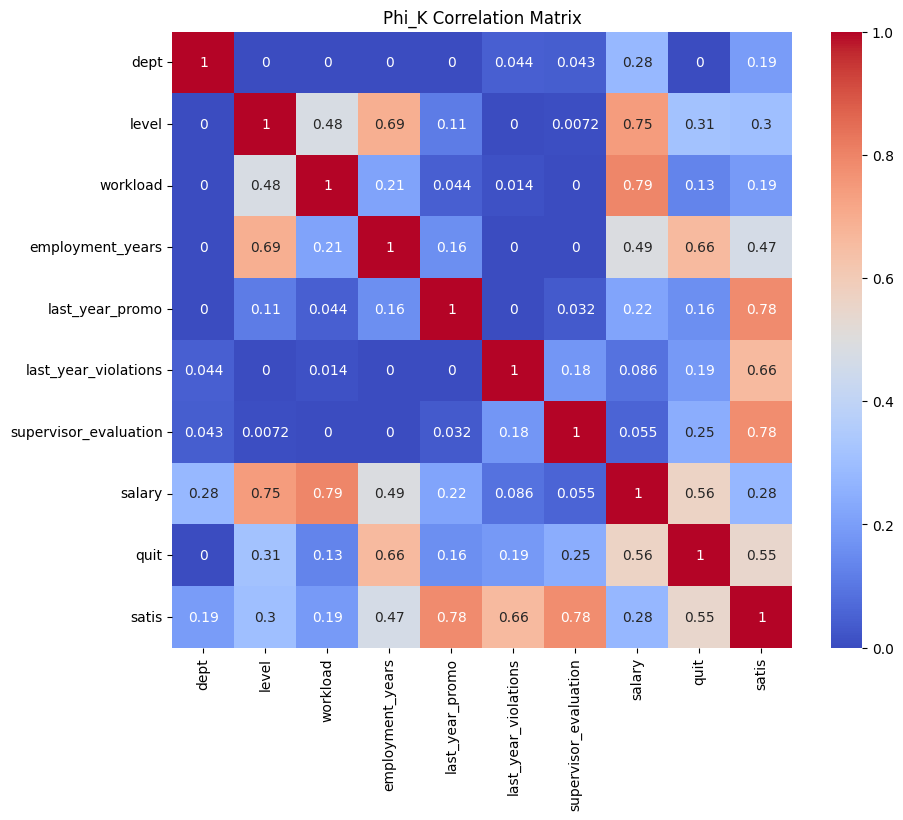

In [50]:
corr_matrix = df_train_quit.phik_matrix(interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'satis'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()